##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

**Note**: Use TensorFlow 2.10 to run this tutorial. Versions above TensorFlow 2.10 may not run successfully.

In [2]:
!pip install remotezip tqdm opencv-python einops 
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0

  Preparing metadata (setup.py) ... -

 done


 done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7934 sha256=07a82e7702ea9b6fb3d1b894c049a46eeed74261ff6a828598bd5b33dd701837
  Stored in directory: /home/kbuilder/.cache/pip/wheels/60/74/6c/b12b4c8fb4b7ab08f495ce17e88f1e98835268af7a8ad5588f
Successfully built remotezip


  Attempting uninstall: keras
    Found existing installation: keras 2.15.0rc0


    Uninstalling keras-2.15.0rc0:


      Successfully uninstalled keras-2.15.0rc0


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0rc0


    Uninstalling tensorflow-estimator-2.15.0rc0:
      Successfully uninstalled tensorflow-estimator-2.15.0rc0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.1.0
    Uninstalling google-auth-oauthlib-1.1.0:
      Successfully uninstalled google-auth-oauthlib-1.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.0


    Uninstalling tensorboard-2.15.0:
      Successfully uninstalled tensorboard-2.15.0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0rc0


    Uninstalling tensorflow-2.15.0rc0:


      Successfully uninstalled tensorflow-2.15.0rc0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

2023-10-27 01:29:52.291653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-27 01:29:52.327803: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-10-27 01:29:52.949253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-27 01:29:52.949379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-27 01:29:52.949390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [4]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<01:07,  4.40it/s]

  1%|          | 2/300 [00:00<01:25,  3.50it/s]

  1%|          | 3/300 [00:00<01:23,  3.58it/s]

  1%|▏         | 4/300 [00:01<01:15,  3.92it/s]

  2%|▏         | 6/300 [00:01<00:47,  6.20it/s]

  3%|▎         | 8/300 [00:01<00:35,  8.23it/s]

  3%|▎         | 10/300 [00:01<00:35,  8.24it/s]

  4%|▍         | 12/300 [00:01<00:29,  9.68it/s]

  5%|▍         | 14/300 [00:02<00:33,  8.62it/s]

  5%|▌         | 16/300 [00:02<00:28,  9.98it/s]

  6%|▌         | 18/300 [00:02<00:25, 11.15it/s]

  7%|▋         | 20/300 [00:02<00:22, 12.22it/s]

  7%|▋         | 22/300 [00:02<00:22, 12.60it/s]

  8%|▊         | 24/300 [00:02<00:23, 11.71it/s]

  9%|▊         | 26/300 [00:02<00:21, 12.68it/s]

  9%|▉         | 28/300 [00:03<00:20, 13.45it/s]

 10%|█         | 30/300 [00:03<00:20, 13.50it/s]

 11%|█         | 32/300 [00:03<00:20, 12.92it/s]

 11%|█▏        | 34/300 [00:03<00:23, 11.39it/s]

 12%|█▏        | 36/300 [00:03<00:22, 11.51it/s]

 13%|█▎        | 38/300 [00:03<00:21, 12.36it/s]

 13%|█▎        | 40/300 [00:03<00:19, 13.45it/s]

 14%|█▍        | 42/300 [00:04<00:18, 13.82it/s]

 15%|█▍        | 44/300 [00:04<00:19, 13.29it/s]

 15%|█▌        | 46/300 [00:04<00:18, 13.94it/s]

 16%|█▌        | 48/300 [00:04<00:17, 14.53it/s]

 17%|█▋        | 50/300 [00:04<00:16, 15.16it/s]

 17%|█▋        | 52/300 [00:04<00:16, 15.11it/s]

 18%|█▊        | 54/300 [00:04<00:16, 14.92it/s]

 19%|█▊        | 56/300 [00:05<00:16, 14.99it/s]

 19%|█▉        | 58/300 [00:05<00:16, 15.10it/s]

 20%|██        | 60/300 [00:05<00:16, 14.39it/s]

 21%|██        | 62/300 [00:05<00:20, 11.68it/s]

 21%|██▏       | 64/300 [00:06<00:41,  5.75it/s]

 22%|██▏       | 66/300 [00:06<00:36,  6.44it/s]

 22%|██▏       | 67/300 [00:06<00:35,  6.59it/s]

 23%|██▎       | 68/300 [00:06<00:35,  6.48it/s]

 23%|██▎       | 70/300 [00:07<00:32,  7.09it/s]

 24%|██▍       | 72/300 [00:07<00:28,  7.89it/s]

 25%|██▍       | 74/300 [00:07<00:24,  9.36it/s]

 25%|██▌       | 76/300 [00:07<00:23,  9.45it/s]

 26%|██▌       | 78/300 [00:07<00:20, 10.58it/s]

 27%|██▋       | 80/300 [00:07<00:18, 11.63it/s]

 27%|██▋       | 82/300 [00:08<00:19, 10.99it/s]

 28%|██▊       | 84/300 [00:08<00:17, 12.02it/s]

 29%|██▊       | 86/300 [00:08<00:17, 12.33it/s]

 29%|██▉       | 88/300 [00:08<00:16, 12.96it/s]

 30%|███       | 90/300 [00:08<00:16, 13.11it/s]

 31%|███       | 92/300 [00:08<00:17, 12.05it/s]

 31%|███▏      | 94/300 [00:09<00:23,  8.85it/s]

 32%|███▏      | 96/300 [00:09<00:21,  9.66it/s]

 33%|███▎      | 98/300 [00:09<00:20,  9.78it/s]

 33%|███▎      | 100/300 [00:09<00:18, 10.90it/s]

 34%|███▍      | 102/300 [00:09<00:17, 11.64it/s]

 35%|███▍      | 104/300 [00:10<00:15, 12.60it/s]

 35%|███▌      | 106/300 [00:10<00:15, 12.13it/s]

 36%|███▌      | 108/300 [00:10<00:15, 12.22it/s]

 37%|███▋      | 110/300 [00:10<00:14, 13.25it/s]

 37%|███▋      | 112/300 [00:10<00:15, 12.16it/s]

 38%|███▊      | 114/300 [00:10<00:15, 11.95it/s]

 39%|███▊      | 116/300 [00:10<00:14, 12.45it/s]

 39%|███▉      | 118/300 [00:11<00:13, 13.14it/s]

 40%|████      | 120/300 [00:11<00:13, 13.67it/s]

 41%|████      | 122/300 [00:11<00:14, 12.36it/s]

 41%|████▏     | 124/300 [00:11<00:15, 11.39it/s]

 42%|████▏     | 126/300 [00:11<00:15, 11.53it/s]

 43%|████▎     | 128/300 [00:11<00:13, 12.79it/s]

 43%|████▎     | 130/300 [00:12<00:14, 12.10it/s]

 44%|████▍     | 132/300 [00:12<00:13, 12.29it/s]

 45%|████▍     | 134/300 [00:12<00:15, 10.74it/s]

 45%|████▌     | 136/300 [00:12<00:14, 11.59it/s]

 46%|████▌     | 138/300 [00:12<00:12, 12.46it/s]

 47%|████▋     | 140/300 [00:12<00:12, 13.20it/s]

 47%|████▋     | 142/300 [00:13<00:11, 13.22it/s]

 48%|████▊     | 144/300 [00:13<00:11, 13.68it/s]

 49%|████▊     | 146/300 [00:13<00:11, 13.96it/s]

 49%|████▉     | 148/300 [00:13<00:11, 13.59it/s]

 50%|█████     | 150/300 [00:13<00:10, 13.68it/s]

 51%|█████     | 152/300 [00:14<00:15,  9.34it/s]

 51%|█████▏    | 154/300 [00:14<00:25,  5.65it/s]

 52%|█████▏    | 155/300 [00:14<00:24,  5.92it/s]

 52%|█████▏    | 157/300 [00:14<00:19,  7.16it/s]

 53%|█████▎    | 158/300 [00:15<00:19,  7.13it/s]

 53%|█████▎    | 160/300 [00:15<00:20,  6.73it/s]

 54%|█████▍    | 162/300 [00:15<00:18,  7.59it/s]

 55%|█████▍    | 164/300 [00:15<00:15,  8.85it/s]

 55%|█████▌    | 166/300 [00:16<00:20,  6.68it/s]

 56%|█████▌    | 167/300 [00:16<00:18,  7.07it/s]

 56%|█████▋    | 169/300 [00:16<00:16,  8.12it/s]

 57%|█████▋    | 170/300 [00:16<00:15,  8.40it/s]

 57%|█████▋    | 172/300 [00:16<00:14,  8.86it/s]

 58%|█████▊    | 173/300 [00:16<00:14,  8.48it/s]

 58%|█████▊    | 174/300 [00:17<00:16,  7.67it/s]

 59%|█████▊    | 176/300 [00:17<00:13,  8.96it/s]

 59%|█████▉    | 178/300 [00:17<00:12,  9.80it/s]

 60%|█████▉    | 179/300 [00:17<00:12,  9.48it/s]

 60%|██████    | 181/300 [00:17<00:12,  9.86it/s]

 61%|██████    | 182/300 [00:18<00:16,  7.22it/s]

 61%|██████    | 183/300 [00:18<00:15,  7.56it/s]

 61%|██████▏   | 184/300 [00:18<00:21,  5.31it/s]

 62%|██████▏   | 185/300 [00:18<00:19,  6.04it/s]

 62%|██████▏   | 187/300 [00:18<00:13,  8.15it/s]

 63%|██████▎   | 189/300 [00:18<00:11,  9.68it/s]

 64%|██████▎   | 191/300 [00:19<00:10, 10.35it/s]

 64%|██████▍   | 193/300 [00:19<00:09, 11.83it/s]

 65%|██████▌   | 195/300 [00:19<00:08, 12.48it/s]

 66%|██████▌   | 197/300 [00:19<00:07, 13.72it/s]

 66%|██████▋   | 199/300 [00:19<00:07, 14.39it/s]

 67%|██████▋   | 201/300 [00:19<00:06, 14.45it/s]

 68%|██████▊   | 203/300 [00:19<00:06, 13.97it/s]

 68%|██████▊   | 205/300 [00:20<00:06, 13.67it/s]

 69%|██████▉   | 207/300 [00:20<00:06, 13.89it/s]

 70%|██████▉   | 209/300 [00:20<00:06, 13.04it/s]

 70%|███████   | 211/300 [00:20<00:07, 12.11it/s]

 71%|███████   | 213/300 [00:20<00:07, 11.69it/s]

 72%|███████▏  | 215/300 [00:20<00:07, 11.58it/s]

 72%|███████▏  | 217/300 [00:21<00:06, 12.04it/s]

 73%|███████▎  | 219/300 [00:21<00:08, 10.02it/s]

 74%|███████▎  | 221/300 [00:21<00:07, 11.02it/s]

 74%|███████▍  | 223/300 [00:21<00:06, 11.22it/s]

 75%|███████▌  | 225/300 [00:21<00:06, 11.93it/s]

 76%|███████▌  | 227/300 [00:21<00:05, 12.90it/s]

 76%|███████▋  | 229/300 [00:22<00:05, 13.78it/s]

 77%|███████▋  | 231/300 [00:22<00:04, 13.99it/s]

 78%|███████▊  | 233/300 [00:22<00:04, 14.71it/s]

 78%|███████▊  | 235/300 [00:22<00:04, 15.11it/s]

 79%|███████▉  | 237/300 [00:22<00:04, 14.07it/s]

 80%|███████▉  | 239/300 [00:22<00:04, 14.92it/s]

 80%|████████  | 241/300 [00:22<00:04, 13.30it/s]

 81%|████████  | 243/300 [00:23<00:07,  8.14it/s]

 82%|████████▏ | 245/300 [00:23<00:06,  8.44it/s]

 82%|████████▏ | 247/300 [00:23<00:06,  8.59it/s]

 83%|████████▎ | 249/300 [00:24<00:05,  8.50it/s]

 84%|████████▎ | 251/300 [00:24<00:05,  9.54it/s]

 84%|████████▍ | 253/300 [00:24<00:04, 10.63it/s]

 85%|████████▌ | 255/300 [00:24<00:03, 11.80it/s]

 86%|████████▌ | 257/300 [00:24<00:03, 12.73it/s]

 86%|████████▋ | 259/300 [00:24<00:03, 13.25it/s]

 87%|████████▋ | 261/300 [00:24<00:02, 14.14it/s]

 88%|████████▊ | 263/300 [00:25<00:03, 10.81it/s]

 88%|████████▊ | 265/300 [00:25<00:03,  9.73it/s]

 89%|████████▉ | 267/300 [00:25<00:03, 10.88it/s]

 90%|████████▉ | 269/300 [00:25<00:02, 11.90it/s]

 90%|█████████ | 271/300 [00:25<00:02, 11.76it/s]

 91%|█████████ | 273/300 [00:25<00:02, 11.70it/s]

 92%|█████████▏| 275/300 [00:26<00:02, 10.43it/s]

 92%|█████████▏| 277/300 [00:26<00:02, 10.75it/s]

 93%|█████████▎| 279/300 [00:26<00:01, 11.63it/s]

 94%|█████████▎| 281/300 [00:26<00:01, 11.99it/s]

 94%|█████████▍| 283/300 [00:26<00:01, 11.37it/s]

 95%|█████████▌| 285/300 [00:27<00:01, 12.16it/s]

 96%|█████████▌| 287/300 [00:27<00:01, 12.18it/s]

 96%|█████████▋| 289/300 [00:27<00:00, 12.67it/s]

 97%|█████████▋| 291/300 [00:27<00:00, 12.72it/s]

 98%|█████████▊| 293/300 [00:27<00:00, 12.52it/s]

 98%|█████████▊| 295/300 [00:27<00:00, 11.62it/s]

 99%|█████████▉| 297/300 [00:28<00:00, 12.12it/s]

100%|█████████▉| 299/300 [00:28<00:00, 12.94it/s]

100%|██████████| 300/300 [00:28<00:00, 10.61it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:10,  9.24it/s]

  2%|▏         | 2/100 [00:00<00:12,  7.57it/s]

  4%|▍         | 4/100 [00:00<00:08, 10.81it/s]

  6%|▌         | 6/100 [00:00<00:08, 10.92it/s]

  8%|▊         | 8/100 [00:00<00:07, 12.87it/s]

 10%|█         | 10/100 [00:00<00:06, 13.95it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.28it/s]

 14%|█▍        | 14/100 [00:01<00:07, 10.84it/s]

 16%|█▌        | 16/100 [00:01<00:08, 10.35it/s]

 18%|█▊        | 18/100 [00:01<00:08,  9.68it/s]

 20%|██        | 20/100 [00:01<00:07, 10.88it/s]

 22%|██▏       | 22/100 [00:02<00:07,  9.86it/s]

 24%|██▍       | 24/100 [00:02<00:08,  9.25it/s]

 26%|██▌       | 26/100 [00:02<00:06, 10.77it/s]

 28%|██▊       | 28/100 [00:02<00:06, 11.86it/s]

 30%|███       | 30/100 [00:02<00:06, 11.52it/s]

 32%|███▏      | 32/100 [00:02<00:06, 10.63it/s]

 34%|███▍      | 34/100 [00:03<00:07,  9.35it/s]

 36%|███▌      | 36/100 [00:03<00:06, 10.43it/s]

 38%|███▊      | 38/100 [00:03<00:05, 11.79it/s]

 40%|████      | 40/100 [00:03<00:05, 10.86it/s]

 42%|████▏     | 42/100 [00:03<00:05, 10.07it/s]

 44%|████▍     | 44/100 [00:04<00:05,  9.42it/s]

 46%|████▌     | 46/100 [00:04<00:05,  9.83it/s]

 48%|████▊     | 48/100 [00:04<00:05, 10.30it/s]

 50%|█████     | 50/100 [00:04<00:05,  9.20it/s]

 51%|█████     | 51/100 [00:04<00:05,  9.01it/s]

 52%|█████▏    | 52/100 [00:05<00:05,  8.51it/s]

 54%|█████▍    | 54/100 [00:05<00:05,  8.52it/s]

 55%|█████▌    | 55/100 [00:05<00:06,  6.83it/s]

 56%|█████▌    | 56/100 [00:05<00:06,  6.65it/s]

 58%|█████▊    | 58/100 [00:05<00:05,  7.91it/s]

 60%|██████    | 60/100 [00:06<00:04,  8.83it/s]

 61%|██████    | 61/100 [00:06<00:04,  8.46it/s]

 62%|██████▏   | 62/100 [00:06<00:04,  8.58it/s]

 63%|██████▎   | 63/100 [00:06<00:04,  8.79it/s]

 65%|██████▌   | 65/100 [00:06<00:03,  9.34it/s]

 67%|██████▋   | 67/100 [00:06<00:03, 10.67it/s]

 69%|██████▉   | 69/100 [00:06<00:02, 11.52it/s]

 71%|███████   | 71/100 [00:07<00:02, 12.04it/s]

 73%|███████▎  | 73/100 [00:07<00:02, 11.40it/s]

 75%|███████▌  | 75/100 [00:07<00:02, 12.31it/s]

 77%|███████▋  | 77/100 [00:07<00:01, 11.73it/s]

 79%|███████▉  | 79/100 [00:07<00:01, 12.83it/s]

 81%|████████  | 81/100 [00:07<00:01, 14.02it/s]

 83%|████████▎ | 83/100 [00:08<00:01, 12.50it/s]

 85%|████████▌ | 85/100 [00:08<00:01, 13.22it/s]

 87%|████████▋ | 87/100 [00:08<00:00, 14.47it/s]

 89%|████████▉ | 89/100 [00:08<00:00, 12.01it/s]

 91%|█████████ | 91/100 [00:08<00:00, 12.75it/s]

 93%|█████████▎| 93/100 [00:08<00:00, 13.37it/s]

 95%|█████████▌| 95/100 [00:08<00:00, 14.51it/s]

 97%|█████████▋| 97/100 [00:09<00:00, 13.77it/s]

 99%|█████████▉| 99/100 [00:09<00:00, 13.45it/s]

100%|██████████| 100/100 [00:09<00:00, 10.75it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:13,  7.57it/s]

  3%|▎         | 3/100 [00:00<00:07, 12.35it/s]

  5%|▌         | 5/100 [00:00<00:07, 12.07it/s]

  7%|▋         | 7/100 [00:00<00:08, 11.57it/s]

  9%|▉         | 9/100 [00:00<00:06, 13.23it/s]

 11%|█         | 11/100 [00:00<00:06, 14.40it/s]

 13%|█▎        | 13/100 [00:00<00:05, 14.76it/s]

 15%|█▌        | 15/100 [00:01<00:05, 14.85it/s]

 17%|█▋        | 17/100 [00:01<00:06, 13.62it/s]

 19%|█▉        | 19/100 [00:01<00:05, 14.67it/s]

 21%|██        | 21/100 [00:01<00:06, 12.31it/s]

 23%|██▎       | 23/100 [00:01<00:06, 11.37it/s]

 25%|██▌       | 25/100 [00:01<00:06, 11.68it/s]

 27%|██▋       | 27/100 [00:02<00:06, 10.46it/s]

 29%|██▉       | 29/100 [00:02<00:06, 11.47it/s]

 31%|███       | 31/100 [00:02<00:06, 11.39it/s]

 33%|███▎      | 33/100 [00:02<00:05, 12.37it/s]

 35%|███▌      | 35/100 [00:02<00:05, 12.62it/s]

 37%|███▋      | 37/100 [00:02<00:05, 12.05it/s]

 39%|███▉      | 39/100 [00:03<00:04, 12.94it/s]

 41%|████      | 41/100 [00:03<00:05, 11.74it/s]

 43%|████▎     | 43/100 [00:03<00:04, 11.58it/s]

 45%|████▌     | 45/100 [00:03<00:04, 11.80it/s]

 47%|████▋     | 47/100 [00:03<00:04, 12.47it/s]

 49%|████▉     | 49/100 [00:03<00:03, 13.22it/s]

 51%|█████     | 51/100 [00:04<00:03, 13.43it/s]

 53%|█████▎    | 53/100 [00:04<00:04, 11.50it/s]

 55%|█████▌    | 55/100 [00:04<00:03, 12.51it/s]

 57%|█████▋    | 57/100 [00:04<00:04,  8.74it/s]

 59%|█████▉    | 59/100 [00:05<00:04,  8.43it/s]

 61%|██████    | 61/100 [00:05<00:03,  9.89it/s]

 63%|██████▎   | 63/100 [00:05<00:03, 11.13it/s]

 65%|██████▌   | 65/100 [00:05<00:02, 11.83it/s]

 67%|██████▋   | 67/100 [00:05<00:02, 12.97it/s]

 69%|██████▉   | 69/100 [00:05<00:02, 13.07it/s]

 71%|███████   | 71/100 [00:05<00:02, 12.24it/s]

 73%|███████▎  | 73/100 [00:06<00:02, 11.34it/s]

 75%|███████▌  | 75/100 [00:06<00:01, 12.61it/s]

 77%|███████▋  | 77/100 [00:06<00:01, 13.31it/s]

 79%|███████▉  | 79/100 [00:06<00:01, 13.73it/s]

 81%|████████  | 81/100 [00:06<00:01, 13.74it/s]

 83%|████████▎ | 83/100 [00:06<00:01, 13.66it/s]

 85%|████████▌ | 85/100 [00:06<00:01, 13.42it/s]

 87%|████████▋ | 87/100 [00:07<00:00, 14.67it/s]

 89%|████████▉ | 89/100 [00:07<00:00, 13.45it/s]

 91%|█████████ | 91/100 [00:07<00:00, 13.71it/s]

 93%|█████████▎| 93/100 [00:07<00:00, 12.43it/s]

 95%|█████████▌| 95/100 [00:07<00:00, 11.14it/s]

 97%|█████████▋| 97/100 [00:07<00:00, 12.24it/s]

 99%|█████████▉| 99/100 [00:08<00:00, 13.29it/s]

100%|██████████| 100/100 [00:08<00:00, 12.31it/s]

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [6]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

2023-10-27 01:30:41.429812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-27 01:30:41.429949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-27 01:30:41.430034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-10-27 01:30:41.430115: W tensorflow/stream_executor

## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

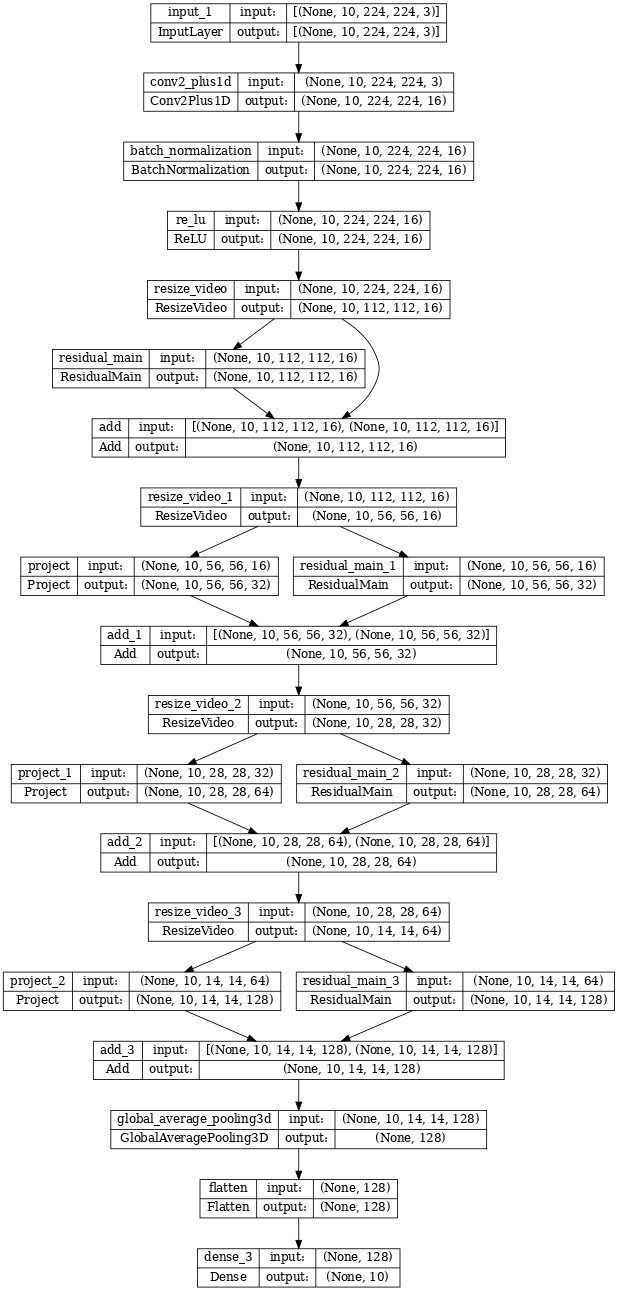

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [17]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


      1/Unknown - 9s 9s/step - loss: 3.2764 - accuracy: 0.0000e+00

      2/Unknown - 15s 6s/step - loss: 3.1638 - accuracy: 0.0000e+00

      3/Unknown - 20s 6s/step - loss: 2.8824 - accuracy: 0.0000e+00

      4/Unknown - 26s 6s/step - loss: 2.7739 - accuracy: 0.0000e+00

      5/Unknown - 32s 6s/step - loss: 2.7152 - accuracy: 0.0250    

      6/Unknown - 37s 6s/step - loss: 2.7389 - accuracy: 0.0417

      7/Unknown - 43s 6s/step - loss: 2.7389 - accuracy: 0.0536

      8/Unknown - 49s 6s/step - loss: 2.6803 - accuracy: 0.0625

      9/Unknown - 55s 6s/step - loss: 2.6625 - accuracy: 0.0694

     10/Unknown - 60s 6s/step - loss: 2.6603 - accuracy: 0.0625

     11/Unknown - 66s 6s/step - loss: 2.6336 - accuracy: 0.0682

     12/Unknown - 71s 6s/step - loss: 2.6588 - accuracy: 0.0625

     13/Unknown - 77s 6s/step - loss: 2.6544 - accuracy: 0.0673

     14/Unknown - 82s 6s/step - loss: 2.6327 - accuracy: 0.0625

     15/Unknown - 88s 6s/step - loss: 2.6270 - accuracy: 0.0667

     16/Unknown - 94s 6s/step - loss: 2.6103 - accuracy: 0.0625

     17/Unknown - 99s 6s/step - loss: 2.5985 - accuracy: 0.0662

     18/Unknown - 105s 6s/step - loss: 2.5830 - accuracy: 0.0694

     19/Unknown - 110s 6s/step - loss: 2.5484 - accuracy: 0.0658

     20/Unknown - 116s 6s/step - loss: 2.5533 - accuracy: 0.0688

     21/Unknown - 121s 6s/step - loss: 2.5517 - accuracy: 0.0655

     22/Unknown - 127s 6s/step - loss: 2.5472 - accuracy: 0.0682

     23/Unknown - 132s 6s/step - loss: 2.5351 - accuracy: 0.0870

     24/Unknown - 138s 6s/step - loss: 2.5246 - accuracy: 0.0938

     25/Unknown - 144s 6s/step - loss: 2.5258 - accuracy: 0.0950

     26/Unknown - 149s 6s/step - loss: 2.5172 - accuracy: 0.0913

     27/Unknown - 155s 6s/step - loss: 2.5059 - accuracy: 0.0880

     28/Unknown - 160s 6s/step - loss: 2.4941 - accuracy: 0.0938

     29/Unknown - 166s 6s/step - loss: 2.4904 - accuracy: 0.0905

     30/Unknown - 171s 6s/step - loss: 2.4793 - accuracy: 0.0958

     31/Unknown - 177s 6s/step - loss: 2.4684 - accuracy: 0.0968

     32/Unknown - 183s 6s/step - loss: 2.4654 - accuracy: 0.1016

     33/Unknown - 188s 6s/step - loss: 2.4571 - accuracy: 0.1098

     34/Unknown - 194s 6s/step - loss: 2.4497 - accuracy: 0.1103

     35/Unknown - 199s 6s/step - loss: 2.4371 - accuracy: 0.1250

     36/Unknown - 205s 6s/step - loss: 2.4460 - accuracy: 0.1215

     37/Unknown - 210s 6s/step - loss: 2.4387 - accuracy: 0.1250

     38/Unknown - 213s 6s/step - loss: 2.4452 - accuracy: 0.1233

38/38 [==============================] - 230s 6s/step - loss: 2.4452 - accuracy: 0.1233 - val_loss: 2.4661 - val_accuracy: 0.1400


Epoch 2/50


 1/38 [..............................] - ETA: 3:24 - loss: 2.2835 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 3:19 - loss: 2.2100 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 3:14 - loss: 2.2855 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 3:09 - loss: 2.2260 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 3:04 - loss: 2.2575 - accuracy: 0.3500

 6/38 [===>..........................] - ETA: 2:59 - loss: 2.2785 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 2:53 - loss: 2.2899 - accuracy: 0.2679

 8/38 [=====>........................] - ETA: 2:47 - loss: 2.2929 - accuracy: 0.2656

 9/38 [======>.......................] - ETA: 2:41 - loss: 2.3279 - accuracy: 0.2361

10/38 [======>.......................] - ETA: 2:36 - loss: 2.2974 - accuracy: 0.2250

11/38 [=======>......................] - ETA: 2:31 - loss: 2.2920 - accuracy: 0.2159

12/38 [========>.....................] - ETA: 2:25 - loss: 2.2888 - accuracy: 0.2083

13/38 [=========>....................] - ETA: 2:19 - loss: 2.2654 - accuracy: 0.2115

14/38 [==========>...................] - ETA: 2:13 - loss: 2.2791 - accuracy: 0.1964

15/38 [==========>...................] - ETA: 2:07 - loss: 2.2715 - accuracy: 0.2000

16/38 [===========>..................] - ETA: 2:01 - loss: 2.2764 - accuracy: 0.1953

17/38 [============>.................] - ETA: 1:56 - loss: 2.2727 - accuracy: 0.1985

18/38 [=============>................] - ETA: 1:50 - loss: 2.2651 - accuracy: 0.1944

19/38 [==============>...............] - ETA: 1:45 - loss: 2.2529 - accuracy: 0.1974

20/38 [==============>...............] - ETA: 1:39 - loss: 2.2321 - accuracy: 0.2000

21/38 [===============>..............] - ETA: 1:34 - loss: 2.2212 - accuracy: 0.1964

22/38 [================>.............] - ETA: 1:28 - loss: 2.2228 - accuracy: 0.1875

23/38 [=================>............] - ETA: 1:22 - loss: 2.2131 - accuracy: 0.1902

24/38 [=================>............] - ETA: 1:17 - loss: 2.2051 - accuracy: 0.1927

25/38 [==================>...........] - ETA: 1:11 - loss: 2.2128 - accuracy: 0.1900

26/38 [===================>..........] - ETA: 1:06 - loss: 2.2081 - accuracy: 0.1923

27/38 [====================>.........] - ETA: 1:00 - loss: 2.2005 - accuracy: 0.1991

28/38 [=====================>........] - ETA: 55s - loss: 2.1882 - accuracy: 0.2098 

29/38 [=====================>........] - ETA: 49s - loss: 2.1946 - accuracy: 0.2069

30/38 [======================>.......] - ETA: 44s - loss: 2.2013 - accuracy: 0.2042

31/38 [=======================>......] - ETA: 38s - loss: 2.2050 - accuracy: 0.2016

32/38 [========================>.....] - ETA: 33s - loss: 2.1988 - accuracy: 0.1992

33/38 [=========================>....] - ETA: 27s - loss: 2.2029 - accuracy: 0.2008

34/38 [=========================>....] - ETA: 22s - loss: 2.1966 - accuracy: 0.2059

35/38 [==========================>...] - ETA: 16s - loss: 2.2037 - accuracy: 0.2071

36/38 [===========================>..] - ETA: 11s - loss: 2.2019 - accuracy: 0.2083

37/38 [============================>.] - ETA: 5s - loss: 2.1923 - accuracy: 0.2095 

38/38 [==============================] - ETA: 0s - loss: 2.1898 - accuracy: 0.2067

38/38 [==============================] - 223s 6s/step - loss: 2.1898 - accuracy: 0.2067 - val_loss: 2.5864 - val_accuracy: 0.1500


Epoch 3/50


 1/38 [..............................] - ETA: 3:32 - loss: 1.9957 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 3:14 - loss: 2.0844 - accuracy: 0.1875

 3/38 [=>............................] - ETA: 3:12 - loss: 2.1106 - accuracy: 0.2083

 4/38 [==>...........................] - ETA: 3:04 - loss: 2.0511 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 2:58 - loss: 2.1897 - accuracy: 0.2000

 6/38 [===>..........................] - ETA: 2:53 - loss: 2.1391 - accuracy: 0.2083

 7/38 [====>.........................] - ETA: 2:47 - loss: 2.1540 - accuracy: 0.1964

 8/38 [=====>........................] - ETA: 2:42 - loss: 2.1026 - accuracy: 0.2344

 9/38 [======>.......................] - ETA: 2:36 - loss: 2.1285 - accuracy: 0.2361

10/38 [======>.......................] - ETA: 2:31 - loss: 2.0945 - accuracy: 0.2500

11/38 [=======>......................] - ETA: 2:26 - loss: 2.0974 - accuracy: 0.2500

12/38 [========>.....................] - ETA: 2:21 - loss: 2.1201 - accuracy: 0.2500

13/38 [=========>....................] - ETA: 2:15 - loss: 2.0818 - accuracy: 0.2500

14/38 [==========>...................] - ETA: 2:10 - loss: 2.0900 - accuracy: 0.2768

15/38 [==========>...................] - ETA: 2:05 - loss: 2.0786 - accuracy: 0.2667

16/38 [===========>..................] - ETA: 2:00 - loss: 2.0894 - accuracy: 0.2656

17/38 [============>.................] - ETA: 1:54 - loss: 2.1371 - accuracy: 0.2574

18/38 [=============>................] - ETA: 1:48 - loss: 2.1219 - accuracy: 0.2639

19/38 [==============>...............] - ETA: 1:43 - loss: 2.1238 - accuracy: 0.2632

20/38 [==============>...............] - ETA: 1:38 - loss: 2.1090 - accuracy: 0.2625

21/38 [===============>..............] - ETA: 1:32 - loss: 2.0966 - accuracy: 0.2679

22/38 [================>.............] - ETA: 1:27 - loss: 2.0706 - accuracy: 0.2841

23/38 [=================>............] - ETA: 1:21 - loss: 2.0774 - accuracy: 0.2826

24/38 [=================>............] - ETA: 1:16 - loss: 2.0675 - accuracy: 0.2760

25/38 [==================>...........] - ETA: 1:11 - loss: 2.0578 - accuracy: 0.2700

26/38 [===================>..........] - ETA: 1:05 - loss: 2.0583 - accuracy: 0.2740

27/38 [====================>.........] - ETA: 1:00 - loss: 2.0397 - accuracy: 0.2778

28/38 [=====================>........] - ETA: 54s - loss: 2.0422 - accuracy: 0.2723 

29/38 [=====================>........] - ETA: 49s - loss: 2.0535 - accuracy: 0.2802

30/38 [======================>.......] - ETA: 43s - loss: 2.0612 - accuracy: 0.2750

31/38 [=======================>......] - ETA: 38s - loss: 2.0757 - accuracy: 0.2702

32/38 [========================>.....] - ETA: 32s - loss: 2.0882 - accuracy: 0.2617

33/38 [=========================>....] - ETA: 27s - loss: 2.1015 - accuracy: 0.2576

34/38 [=========================>....] - ETA: 21s - loss: 2.0880 - accuracy: 0.2537

35/38 [==========================>...] - ETA: 16s - loss: 2.0852 - accuracy: 0.2536

36/38 [===========================>..] - ETA: 10s - loss: 2.0703 - accuracy: 0.2639

37/38 [============================>.] - ETA: 5s - loss: 2.0617 - accuracy: 0.2669 

38/38 [==============================] - ETA: 0s - loss: 2.0602 - accuracy: 0.2667

38/38 [==============================] - 222s 6s/step - loss: 2.0602 - accuracy: 0.2667 - val_loss: 2.7133 - val_accuracy: 0.1200


Epoch 4/50


 1/38 [..............................] - ETA: 3:25 - loss: 2.2741 - accuracy: 0.0000e+00

 2/38 [>.............................] - ETA: 3:23 - loss: 2.0492 - accuracy: 0.1875    

 3/38 [=>............................] - ETA: 3:12 - loss: 1.9496 - accuracy: 0.3333

 4/38 [==>...........................] - ETA: 3:07 - loss: 1.9063 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 3:01 - loss: 1.8849 - accuracy: 0.3500

 6/38 [===>..........................] - ETA: 2:56 - loss: 1.8307 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 2:51 - loss: 1.8372 - accuracy: 0.3750

 8/38 [=====>........................] - ETA: 2:46 - loss: 1.8475 - accuracy: 0.3906

 9/38 [======>.......................] - ETA: 2:40 - loss: 1.8210 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 2:34 - loss: 1.8056 - accuracy: 0.4125

11/38 [=======>......................] - ETA: 2:28 - loss: 1.7920 - accuracy: 0.4091

12/38 [========>.....................] - ETA: 2:23 - loss: 1.8129 - accuracy: 0.3854

13/38 [=========>....................] - ETA: 2:17 - loss: 1.8345 - accuracy: 0.3750

14/38 [==========>...................] - ETA: 2:12 - loss: 1.8139 - accuracy: 0.3839

15/38 [==========>...................] - ETA: 2:06 - loss: 1.8030 - accuracy: 0.3833

16/38 [===========>..................] - ETA: 2:00 - loss: 1.7844 - accuracy: 0.3906

17/38 [============>.................] - ETA: 1:55 - loss: 1.7741 - accuracy: 0.3897

18/38 [=============>................] - ETA: 1:49 - loss: 1.7594 - accuracy: 0.3958

19/38 [==============>...............] - ETA: 1:44 - loss: 1.7750 - accuracy: 0.3947

20/38 [==============>...............] - ETA: 1:38 - loss: 1.7834 - accuracy: 0.3938

21/38 [===============>..............] - ETA: 1:33 - loss: 1.7796 - accuracy: 0.3869

22/38 [================>.............] - ETA: 1:27 - loss: 1.7969 - accuracy: 0.3750

23/38 [=================>............] - ETA: 1:22 - loss: 1.7916 - accuracy: 0.3804

24/38 [=================>............] - ETA: 1:16 - loss: 1.8239 - accuracy: 0.3750

25/38 [==================>...........] - ETA: 1:11 - loss: 1.8222 - accuracy: 0.3750

26/38 [===================>..........] - ETA: 1:05 - loss: 1.8039 - accuracy: 0.3846

27/38 [====================>.........] - ETA: 1:00 - loss: 1.8146 - accuracy: 0.3843

28/38 [=====================>........] - ETA: 54s - loss: 1.8276 - accuracy: 0.3705 

29/38 [=====================>........] - ETA: 49s - loss: 1.8129 - accuracy: 0.3707

30/38 [======================>.......] - ETA: 43s - loss: 1.8083 - accuracy: 0.3792

31/38 [=======================>......] - ETA: 38s - loss: 1.8008 - accuracy: 0.3831

32/38 [========================>.....] - ETA: 32s - loss: 1.7960 - accuracy: 0.3789

33/38 [=========================>....] - ETA: 27s - loss: 1.8111 - accuracy: 0.3750

34/38 [=========================>....] - ETA: 21s - loss: 1.8187 - accuracy: 0.3750

35/38 [==========================>...] - ETA: 16s - loss: 1.8284 - accuracy: 0.3750

36/38 [===========================>..] - ETA: 10s - loss: 1.8527 - accuracy: 0.3681

37/38 [============================>.] - ETA: 5s - loss: 1.8711 - accuracy: 0.3649 

38/38 [==============================] - ETA: 0s - loss: 1.8716 - accuracy: 0.3633

38/38 [==============================] - 221s 6s/step - loss: 1.8716 - accuracy: 0.3633 - val_loss: 2.4647 - val_accuracy: 0.1800


Epoch 5/50


 1/38 [..............................] - ETA: 3:20 - loss: 2.3283 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 3:18 - loss: 1.9112 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 3:11 - loss: 1.8811 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 3:05 - loss: 1.8311 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 2:59 - loss: 1.8257 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 2:54 - loss: 1.8990 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 2:49 - loss: 1.9311 - accuracy: 0.3214

 8/38 [=====>........................] - ETA: 2:44 - loss: 1.8910 - accuracy: 0.3281

 9/38 [======>.......................] - ETA: 2:38 - loss: 1.8769 - accuracy: 0.3333

10/38 [======>.......................] - ETA: 2:32 - loss: 1.8755 - accuracy: 0.3375

11/38 [=======>......................] - ETA: 2:26 - loss: 1.8387 - accuracy: 0.3409

12/38 [========>.....................] - ETA: 2:21 - loss: 1.8679 - accuracy: 0.3333

13/38 [=========>....................] - ETA: 2:15 - loss: 1.8952 - accuracy: 0.3173

14/38 [==========>...................] - ETA: 2:10 - loss: 1.8972 - accuracy: 0.3304

15/38 [==========>...................] - ETA: 2:05 - loss: 1.8867 - accuracy: 0.3333

16/38 [===========>..................] - ETA: 1:59 - loss: 1.8782 - accuracy: 0.3281

17/38 [============>.................] - ETA: 1:54 - loss: 1.8654 - accuracy: 0.3382

18/38 [=============>................] - ETA: 1:48 - loss: 1.8522 - accuracy: 0.3542

19/38 [==============>...............] - ETA: 1:43 - loss: 1.8284 - accuracy: 0.3553

20/38 [==============>...............] - ETA: 1:37 - loss: 1.8032 - accuracy: 0.3688

21/38 [===============>..............] - ETA: 1:32 - loss: 1.8024 - accuracy: 0.3750

22/38 [================>.............] - ETA: 1:27 - loss: 1.8140 - accuracy: 0.3693

23/38 [=================>............] - ETA: 1:21 - loss: 1.7878 - accuracy: 0.3804

24/38 [=================>............] - ETA: 1:16 - loss: 1.7862 - accuracy: 0.3802

25/38 [==================>...........] - ETA: 1:10 - loss: 1.7944 - accuracy: 0.3700

26/38 [===================>..........] - ETA: 1:05 - loss: 1.7923 - accuracy: 0.3702

27/38 [====================>.........] - ETA: 59s - loss: 1.7943 - accuracy: 0.3704 

28/38 [=====================>........] - ETA: 54s - loss: 1.8033 - accuracy: 0.3705

29/38 [=====================>........] - ETA: 49s - loss: 1.7940 - accuracy: 0.3793

30/38 [======================>.......] - ETA: 43s - loss: 1.7996 - accuracy: 0.3750

31/38 [=======================>......] - ETA: 38s - loss: 1.8060 - accuracy: 0.3669

32/38 [========================>.....] - ETA: 32s - loss: 1.7908 - accuracy: 0.3711

33/38 [=========================>....] - ETA: 27s - loss: 1.7811 - accuracy: 0.3712

34/38 [=========================>....] - ETA: 21s - loss: 1.7770 - accuracy: 0.3676

35/38 [==========================>...] - ETA: 16s - loss: 1.7599 - accuracy: 0.3750

36/38 [===========================>..] - ETA: 10s - loss: 1.7787 - accuracy: 0.3681

37/38 [============================>.] - ETA: 5s - loss: 1.7811 - accuracy: 0.3682 

38/38 [==============================] - ETA: 0s - loss: 1.7901 - accuracy: 0.3667

38/38 [==============================] - 220s 6s/step - loss: 1.7901 - accuracy: 0.3667 - val_loss: 2.7002 - val_accuracy: 0.1500


Epoch 6/50


 1/38 [..............................] - ETA: 3:24 - loss: 1.7462 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 3:17 - loss: 1.7232 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 3:13 - loss: 1.6406 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 3:05 - loss: 1.7133 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 3:00 - loss: 1.6859 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 2:55 - loss: 1.7218 - accuracy: 0.3542

 7/38 [====>.........................] - ETA: 2:50 - loss: 1.7018 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 2:45 - loss: 1.7273 - accuracy: 0.4062

 9/38 [======>.......................] - ETA: 2:40 - loss: 1.7459 - accuracy: 0.4167

10/38 [======>.......................] - ETA: 2:35 - loss: 1.7209 - accuracy: 0.4125

11/38 [=======>......................] - ETA: 2:28 - loss: 1.7717 - accuracy: 0.3864

12/38 [========>.....................] - ETA: 2:23 - loss: 1.7960 - accuracy: 0.4062

13/38 [=========>....................] - ETA: 2:18 - loss: 1.7673 - accuracy: 0.4135

14/38 [==========>...................] - ETA: 2:12 - loss: 1.7562 - accuracy: 0.4107

15/38 [==========>...................] - ETA: 2:07 - loss: 1.7535 - accuracy: 0.4167

16/38 [===========>..................] - ETA: 2:01 - loss: 1.7388 - accuracy: 0.4141

17/38 [============>.................] - ETA: 1:55 - loss: 1.7632 - accuracy: 0.3897

18/38 [=============>................] - ETA: 1:50 - loss: 1.7766 - accuracy: 0.3819

19/38 [==============>...............] - ETA: 1:44 - loss: 1.7780 - accuracy: 0.3816

20/38 [==============>...............] - ETA: 1:39 - loss: 1.7855 - accuracy: 0.3812

21/38 [===============>..............] - ETA: 1:33 - loss: 1.7897 - accuracy: 0.3810

22/38 [================>.............] - ETA: 1:28 - loss: 1.7939 - accuracy: 0.3750

23/38 [=================>............] - ETA: 1:22 - loss: 1.7983 - accuracy: 0.3804

24/38 [=================>............] - ETA: 1:17 - loss: 1.7900 - accuracy: 0.3854

25/38 [==================>...........] - ETA: 1:11 - loss: 1.7933 - accuracy: 0.3800

26/38 [===================>..........] - ETA: 1:05 - loss: 1.7764 - accuracy: 0.3798

27/38 [====================>.........] - ETA: 1:00 - loss: 1.7553 - accuracy: 0.3981

28/38 [=====================>........] - ETA: 54s - loss: 1.7474 - accuracy: 0.4062 

29/38 [=====================>........] - ETA: 49s - loss: 1.7484 - accuracy: 0.4009

30/38 [======================>.......] - ETA: 43s - loss: 1.7732 - accuracy: 0.3917

31/38 [=======================>......] - ETA: 38s - loss: 1.7818 - accuracy: 0.3911

32/38 [========================>.....] - ETA: 32s - loss: 1.7991 - accuracy: 0.3828

33/38 [=========================>....] - ETA: 27s - loss: 1.8036 - accuracy: 0.3750

34/38 [=========================>....] - ETA: 21s - loss: 1.7933 - accuracy: 0.3787

35/38 [==========================>...] - ETA: 16s - loss: 1.7823 - accuracy: 0.3857

36/38 [===========================>..] - ETA: 10s - loss: 1.7698 - accuracy: 0.3889

37/38 [============================>.] - ETA: 5s - loss: 1.7634 - accuracy: 0.3919 

38/38 [==============================] - ETA: 0s - loss: 1.7632 - accuracy: 0.3867

38/38 [==============================] - 221s 6s/step - loss: 1.7632 - accuracy: 0.3867 - val_loss: 2.6759 - val_accuracy: 0.1600


Epoch 7/50


 1/38 [..............................] - ETA: 3:22 - loss: 1.4002 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 3:18 - loss: 1.7403 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 3:15 - loss: 1.7678 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 3:08 - loss: 1.7046 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 3:02 - loss: 1.8160 - accuracy: 0.3500

 6/38 [===>..........................] - ETA: 2:56 - loss: 1.7191 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 2:50 - loss: 1.6745 - accuracy: 0.3929

 8/38 [=====>........................] - ETA: 2:44 - loss: 1.7418 - accuracy: 0.3750

 9/38 [======>.......................] - ETA: 2:38 - loss: 1.7297 - accuracy: 0.3750

10/38 [======>.......................] - ETA: 2:33 - loss: 1.7553 - accuracy: 0.3875

11/38 [=======>......................] - ETA: 2:28 - loss: 1.7440 - accuracy: 0.3864

12/38 [========>.....................] - ETA: 2:22 - loss: 1.7477 - accuracy: 0.3542

13/38 [=========>....................] - ETA: 2:17 - loss: 1.7994 - accuracy: 0.3462

14/38 [==========>...................] - ETA: 2:12 - loss: 1.7811 - accuracy: 0.3661

15/38 [==========>...................] - ETA: 2:06 - loss: 1.7672 - accuracy: 0.3833

16/38 [===========>..................] - ETA: 2:01 - loss: 1.7820 - accuracy: 0.3672

17/38 [============>.................] - ETA: 1:55 - loss: 1.7704 - accuracy: 0.3676

18/38 [=============>................] - ETA: 1:50 - loss: 1.7657 - accuracy: 0.3611

19/38 [==============>...............] - ETA: 1:44 - loss: 1.7848 - accuracy: 0.3421

20/38 [==============>...............] - ETA: 1:39 - loss: 1.7547 - accuracy: 0.3562

21/38 [===============>..............] - ETA: 1:34 - loss: 1.7613 - accuracy: 0.3571

22/38 [================>.............] - ETA: 1:28 - loss: 1.7594 - accuracy: 0.3523

23/38 [=================>............] - ETA: 1:23 - loss: 1.7479 - accuracy: 0.3533

24/38 [=================>............] - ETA: 1:17 - loss: 1.7532 - accuracy: 0.3594

25/38 [==================>...........] - ETA: 1:12 - loss: 1.7661 - accuracy: 0.3600

26/38 [===================>..........] - ETA: 1:06 - loss: 1.7533 - accuracy: 0.3654

27/38 [====================>.........] - ETA: 1:00 - loss: 1.7345 - accuracy: 0.3750

28/38 [=====================>........] - ETA: 55s - loss: 1.7308 - accuracy: 0.3750 

29/38 [=====================>........] - ETA: 49s - loss: 1.7298 - accuracy: 0.3793

30/38 [======================>.......] - ETA: 44s - loss: 1.7361 - accuracy: 0.3708

31/38 [=======================>......] - ETA: 38s - loss: 1.7463 - accuracy: 0.3669

32/38 [========================>.....] - ETA: 33s - loss: 1.7582 - accuracy: 0.3594

33/38 [=========================>....] - ETA: 27s - loss: 1.7541 - accuracy: 0.3636

34/38 [=========================>....] - ETA: 22s - loss: 1.7361 - accuracy: 0.3713

35/38 [==========================>...] - ETA: 16s - loss: 1.7307 - accuracy: 0.3750

36/38 [===========================>..] - ETA: 11s - loss: 1.7342 - accuracy: 0.3750

37/38 [============================>.] - ETA: 5s - loss: 1.7221 - accuracy: 0.3818 

38/38 [==============================] - ETA: 0s - loss: 1.7130 - accuracy: 0.3833

38/38 [==============================] - 223s 6s/step - loss: 1.7130 - accuracy: 0.3833 - val_loss: 2.3038 - val_accuracy: 0.2200


Epoch 8/50


 1/38 [..............................] - ETA: 3:20 - loss: 1.3200 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 3:16 - loss: 1.5284 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 3:10 - loss: 1.5682 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 3:05 - loss: 1.6702 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 2:59 - loss: 1.5198 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 2:55 - loss: 1.5252 - accuracy: 0.3542

 7/38 [====>.........................] - ETA: 2:48 - loss: 1.5325 - accuracy: 0.3750

 8/38 [=====>........................] - ETA: 2:42 - loss: 1.5420 - accuracy: 0.3281

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.5730 - accuracy: 0.3194

10/38 [======>.......................] - ETA: 2:32 - loss: 1.5667 - accuracy: 0.3250

11/38 [=======>......................] - ETA: 2:26 - loss: 1.5599 - accuracy: 0.3409

12/38 [========>.....................] - ETA: 2:21 - loss: 1.5523 - accuracy: 0.3542

13/38 [=========>....................] - ETA: 2:16 - loss: 1.5630 - accuracy: 0.3558

14/38 [==========>...................] - ETA: 2:10 - loss: 1.5879 - accuracy: 0.3571

15/38 [==========>...................] - ETA: 2:05 - loss: 1.5646 - accuracy: 0.3750

16/38 [===========>..................] - ETA: 1:59 - loss: 1.5730 - accuracy: 0.3594

17/38 [============>.................] - ETA: 1:54 - loss: 1.5970 - accuracy: 0.3603

18/38 [=============>................] - ETA: 1:48 - loss: 1.5947 - accuracy: 0.3681

19/38 [==============>...............] - ETA: 1:43 - loss: 1.6046 - accuracy: 0.3684

20/38 [==============>...............] - ETA: 1:38 - loss: 1.6170 - accuracy: 0.3562

21/38 [===============>..............] - ETA: 1:32 - loss: 1.6395 - accuracy: 0.3571

22/38 [================>.............] - ETA: 1:27 - loss: 1.6559 - accuracy: 0.3466

23/38 [=================>............] - ETA: 1:21 - loss: 1.6423 - accuracy: 0.3478

24/38 [=================>............] - ETA: 1:16 - loss: 1.6299 - accuracy: 0.3594

25/38 [==================>...........] - ETA: 1:10 - loss: 1.6197 - accuracy: 0.3650

26/38 [===================>..........] - ETA: 1:05 - loss: 1.6174 - accuracy: 0.3654

27/38 [====================>.........] - ETA: 59s - loss: 1.6237 - accuracy: 0.3657 

28/38 [=====================>........] - ETA: 54s - loss: 1.6158 - accuracy: 0.3750

29/38 [=====================>........] - ETA: 49s - loss: 1.6100 - accuracy: 0.3707

30/38 [======================>.......] - ETA: 43s - loss: 1.6045 - accuracy: 0.3833

31/38 [=======================>......] - ETA: 38s - loss: 1.6111 - accuracy: 0.3871

32/38 [========================>.....] - ETA: 32s - loss: 1.5888 - accuracy: 0.3984

33/38 [=========================>....] - ETA: 27s - loss: 1.5998 - accuracy: 0.3977

34/38 [=========================>....] - ETA: 21s - loss: 1.5846 - accuracy: 0.4081

35/38 [==========================>...] - ETA: 16s - loss: 1.5917 - accuracy: 0.4071

36/38 [===========================>..] - ETA: 10s - loss: 1.5934 - accuracy: 0.4028

37/38 [============================>.] - ETA: 5s - loss: 1.6035 - accuracy: 0.3986 

38/38 [==============================] - ETA: 0s - loss: 1.6025 - accuracy: 0.4000

38/38 [==============================] - 222s 6s/step - loss: 1.6025 - accuracy: 0.4000 - val_loss: 2.6929 - val_accuracy: 0.1700


Epoch 9/50


 1/38 [..............................] - ETA: 3:22 - loss: 1.6945 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 3:15 - loss: 1.5506 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 3:10 - loss: 1.5555 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 3:06 - loss: 1.7308 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 2:59 - loss: 1.7631 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 2:54 - loss: 1.7240 - accuracy: 0.3750

 7/38 [====>.........................] - ETA: 2:48 - loss: 1.6854 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 2:43 - loss: 1.5987 - accuracy: 0.4844

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.6404 - accuracy: 0.4583

10/38 [======>.......................] - ETA: 2:31 - loss: 1.6099 - accuracy: 0.4750

11/38 [=======>......................] - ETA: 2:26 - loss: 1.5975 - accuracy: 0.4659

12/38 [========>.....................] - ETA: 2:21 - loss: 1.5944 - accuracy: 0.4688

13/38 [=========>....................] - ETA: 2:15 - loss: 1.6029 - accuracy: 0.4808

14/38 [==========>...................] - ETA: 2:10 - loss: 1.6191 - accuracy: 0.4643

15/38 [==========>...................] - ETA: 2:04 - loss: 1.5791 - accuracy: 0.4833

16/38 [===========>..................] - ETA: 1:59 - loss: 1.5934 - accuracy: 0.4766

17/38 [============>.................] - ETA: 1:54 - loss: 1.6010 - accuracy: 0.4632

18/38 [=============>................] - ETA: 1:48 - loss: 1.6042 - accuracy: 0.4722

19/38 [==============>...............] - ETA: 1:43 - loss: 1.5654 - accuracy: 0.4934

20/38 [==============>...............] - ETA: 1:38 - loss: 1.6335 - accuracy: 0.4688

21/38 [===============>..............] - ETA: 1:32 - loss: 1.6445 - accuracy: 0.4583

22/38 [================>.............] - ETA: 1:27 - loss: 1.6459 - accuracy: 0.4489

23/38 [=================>............] - ETA: 1:21 - loss: 1.6388 - accuracy: 0.4457

24/38 [=================>............] - ETA: 1:16 - loss: 1.6410 - accuracy: 0.4479

25/38 [==================>...........] - ETA: 1:10 - loss: 1.6339 - accuracy: 0.4400

26/38 [===================>..........] - ETA: 1:05 - loss: 1.6286 - accuracy: 0.4423

27/38 [====================>.........] - ETA: 59s - loss: 1.6147 - accuracy: 0.4491 

28/38 [=====================>........] - ETA: 54s - loss: 1.6048 - accuracy: 0.4464

29/38 [=====================>........] - ETA: 48s - loss: 1.5935 - accuracy: 0.4612

30/38 [======================>.......] - ETA: 43s - loss: 1.5982 - accuracy: 0.4583

31/38 [=======================>......] - ETA: 38s - loss: 1.5856 - accuracy: 0.4597

32/38 [========================>.....] - ETA: 32s - loss: 1.5737 - accuracy: 0.4648

33/38 [=========================>....] - ETA: 27s - loss: 1.5689 - accuracy: 0.4659

34/38 [=========================>....] - ETA: 21s - loss: 1.5837 - accuracy: 0.4632

35/38 [==========================>...] - ETA: 16s - loss: 1.5669 - accuracy: 0.4679

36/38 [===========================>..] - ETA: 10s - loss: 1.5608 - accuracy: 0.4653

37/38 [============================>.] - ETA: 5s - loss: 1.5481 - accuracy: 0.4764 

38/38 [==============================] - ETA: 0s - loss: 1.5444 - accuracy: 0.4767

38/38 [==============================] - 220s 6s/step - loss: 1.5444 - accuracy: 0.4767 - val_loss: 2.6629 - val_accuracy: 0.1800


Epoch 10/50


 1/38 [..............................] - ETA: 3:17 - loss: 1.4426 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 3:14 - loss: 1.4313 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 3:08 - loss: 1.3319 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 3:02 - loss: 1.3613 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 2:58 - loss: 1.5072 - accuracy: 0.4000

 6/38 [===>..........................] - ETA: 2:54 - loss: 1.4811 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 2:49 - loss: 1.4697 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 2:42 - loss: 1.4959 - accuracy: 0.4062

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.4866 - accuracy: 0.4306

10/38 [======>.......................] - ETA: 2:32 - loss: 1.4430 - accuracy: 0.4500

11/38 [=======>......................] - ETA: 2:26 - loss: 1.5018 - accuracy: 0.4318

12/38 [========>.....................] - ETA: 2:21 - loss: 1.5346 - accuracy: 0.4271

13/38 [=========>....................] - ETA: 2:15 - loss: 1.5667 - accuracy: 0.4135

14/38 [==========>...................] - ETA: 2:10 - loss: 1.5350 - accuracy: 0.4286

15/38 [==========>...................] - ETA: 2:04 - loss: 1.5614 - accuracy: 0.4083

16/38 [===========>..................] - ETA: 1:59 - loss: 1.5485 - accuracy: 0.4219

17/38 [============>.................] - ETA: 1:53 - loss: 1.5190 - accuracy: 0.4412

18/38 [=============>................] - ETA: 1:48 - loss: 1.5160 - accuracy: 0.4444

19/38 [==============>...............] - ETA: 1:43 - loss: 1.5193 - accuracy: 0.4408

20/38 [==============>...............] - ETA: 1:37 - loss: 1.5288 - accuracy: 0.4437

21/38 [===============>..............] - ETA: 1:32 - loss: 1.5346 - accuracy: 0.4405

22/38 [================>.............] - ETA: 1:26 - loss: 1.5388 - accuracy: 0.4489

23/38 [=================>............] - ETA: 1:21 - loss: 1.5356 - accuracy: 0.4457

24/38 [=================>............] - ETA: 1:15 - loss: 1.5159 - accuracy: 0.4479

25/38 [==================>...........] - ETA: 1:10 - loss: 1.5147 - accuracy: 0.4500

26/38 [===================>..........] - ETA: 1:05 - loss: 1.5055 - accuracy: 0.4567

27/38 [====================>.........] - ETA: 59s - loss: 1.4787 - accuracy: 0.4676 

28/38 [=====================>........] - ETA: 54s - loss: 1.4737 - accuracy: 0.4688

29/38 [=====================>........] - ETA: 48s - loss: 1.4878 - accuracy: 0.4569

30/38 [======================>.......] - ETA: 43s - loss: 1.4778 - accuracy: 0.4625

31/38 [=======================>......] - ETA: 38s - loss: 1.4621 - accuracy: 0.4677

32/38 [========================>.....] - ETA: 32s - loss: 1.4485 - accuracy: 0.4805

33/38 [=========================>....] - ETA: 27s - loss: 1.4388 - accuracy: 0.4811

34/38 [=========================>....] - ETA: 21s - loss: 1.4502 - accuracy: 0.4779

35/38 [==========================>...] - ETA: 16s - loss: 1.4448 - accuracy: 0.4821

36/38 [===========================>..] - ETA: 10s - loss: 1.4596 - accuracy: 0.4757

37/38 [============================>.] - ETA: 5s - loss: 1.4659 - accuracy: 0.4696 

38/38 [==============================] - ETA: 0s - loss: 1.4557 - accuracy: 0.4767

38/38 [==============================] - 220s 6s/step - loss: 1.4557 - accuracy: 0.4767 - val_loss: 2.2244 - val_accuracy: 0.2300


Epoch 11/50


 1/38 [..............................] - ETA: 3:19 - loss: 0.8162 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:21 - loss: 1.1853 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 3:15 - loss: 1.1904 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 3:07 - loss: 1.2828 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 3:00 - loss: 1.3072 - accuracy: 0.5750

 6/38 [===>..........................] - ETA: 2:56 - loss: 1.3299 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 2:50 - loss: 1.2626 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 2:44 - loss: 1.2630 - accuracy: 0.5938

 9/38 [======>.......................] - ETA: 2:38 - loss: 1.2682 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 2:33 - loss: 1.2533 - accuracy: 0.5750

11/38 [=======>......................] - ETA: 2:27 - loss: 1.3304 - accuracy: 0.5455

12/38 [========>.....................] - ETA: 2:22 - loss: 1.3648 - accuracy: 0.5312

13/38 [=========>....................] - ETA: 2:16 - loss: 1.3558 - accuracy: 0.5385

14/38 [==========>...................] - ETA: 2:10 - loss: 1.3433 - accuracy: 0.5446

15/38 [==========>...................] - ETA: 2:05 - loss: 1.3604 - accuracy: 0.5500

16/38 [===========>..................] - ETA: 1:59 - loss: 1.3935 - accuracy: 0.5391

17/38 [============>.................] - ETA: 1:54 - loss: 1.3992 - accuracy: 0.5294

18/38 [=============>................] - ETA: 1:49 - loss: 1.3772 - accuracy: 0.5417

19/38 [==============>...............] - ETA: 1:43 - loss: 1.3836 - accuracy: 0.5395

20/38 [==============>...............] - ETA: 1:38 - loss: 1.3867 - accuracy: 0.5375

21/38 [===============>..............] - ETA: 1:32 - loss: 1.3790 - accuracy: 0.5357

22/38 [================>.............] - ETA: 1:27 - loss: 1.3954 - accuracy: 0.5227

23/38 [=================>............] - ETA: 1:21 - loss: 1.3972 - accuracy: 0.5272

24/38 [=================>............] - ETA: 1:16 - loss: 1.3849 - accuracy: 0.5365

25/38 [==================>...........] - ETA: 1:11 - loss: 1.3753 - accuracy: 0.5400

26/38 [===================>..........] - ETA: 1:05 - loss: 1.3699 - accuracy: 0.5385

27/38 [====================>.........] - ETA: 1:00 - loss: 1.3769 - accuracy: 0.5370

28/38 [=====================>........] - ETA: 54s - loss: 1.3869 - accuracy: 0.5223 

29/38 [=====================>........] - ETA: 49s - loss: 1.3788 - accuracy: 0.5216

30/38 [======================>.......] - ETA: 43s - loss: 1.3753 - accuracy: 0.5250

31/38 [=======================>......] - ETA: 38s - loss: 1.3703 - accuracy: 0.5202

32/38 [========================>.....] - ETA: 32s - loss: 1.3557 - accuracy: 0.5312

33/38 [=========================>....] - ETA: 27s - loss: 1.3589 - accuracy: 0.5303

34/38 [=========================>....] - ETA: 21s - loss: 1.3644 - accuracy: 0.5221

35/38 [==========================>...] - ETA: 16s - loss: 1.3651 - accuracy: 0.5214

36/38 [===========================>..] - ETA: 10s - loss: 1.3652 - accuracy: 0.5208

37/38 [============================>.] - ETA: 5s - loss: 1.3634 - accuracy: 0.5203 

38/38 [==============================] - ETA: 0s - loss: 1.3617 - accuracy: 0.5200

38/38 [==============================] - 220s 6s/step - loss: 1.3617 - accuracy: 0.5200 - val_loss: 2.1875 - val_accuracy: 0.3200


Epoch 12/50


 1/38 [..............................] - ETA: 3:22 - loss: 1.9457 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 3:10 - loss: 1.5958 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 3:09 - loss: 1.5638 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 3:04 - loss: 1.5658 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 2:58 - loss: 1.5675 - accuracy: 0.4750

 6/38 [===>..........................] - ETA: 2:53 - loss: 1.4917 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 2:48 - loss: 1.4420 - accuracy: 0.5000

 8/38 [=====>........................] - ETA: 2:42 - loss: 1.4112 - accuracy: 0.5156

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.4032 - accuracy: 0.5139

10/38 [======>.......................] - ETA: 2:32 - loss: 1.3890 - accuracy: 0.5000

11/38 [=======>......................] - ETA: 2:26 - loss: 1.3647 - accuracy: 0.5114

12/38 [========>.....................] - ETA: 2:21 - loss: 1.3777 - accuracy: 0.5104

13/38 [=========>....................] - ETA: 2:16 - loss: 1.3603 - accuracy: 0.5192

14/38 [==========>...................] - ETA: 2:10 - loss: 1.3981 - accuracy: 0.5179

15/38 [==========>...................] - ETA: 2:05 - loss: 1.3886 - accuracy: 0.5333

16/38 [===========>..................] - ETA: 2:00 - loss: 1.3764 - accuracy: 0.5391

17/38 [============>.................] - ETA: 1:54 - loss: 1.3849 - accuracy: 0.5368

18/38 [=============>................] - ETA: 1:49 - loss: 1.3795 - accuracy: 0.5347

19/38 [==============>...............] - ETA: 1:43 - loss: 1.3807 - accuracy: 0.5263

20/38 [==============>...............] - ETA: 1:38 - loss: 1.3802 - accuracy: 0.5250

21/38 [===============>..............] - ETA: 1:32 - loss: 1.3731 - accuracy: 0.5298

22/38 [================>.............] - ETA: 1:27 - loss: 1.3784 - accuracy: 0.5227

23/38 [=================>............] - ETA: 1:21 - loss: 1.3906 - accuracy: 0.5163

24/38 [=================>............] - ETA: 1:16 - loss: 1.3688 - accuracy: 0.5260

25/38 [==================>...........] - ETA: 1:10 - loss: 1.3566 - accuracy: 0.5350

26/38 [===================>..........] - ETA: 1:05 - loss: 1.3737 - accuracy: 0.5288

27/38 [====================>.........] - ETA: 59s - loss: 1.3540 - accuracy: 0.5370 

28/38 [=====================>........] - ETA: 54s - loss: 1.3490 - accuracy: 0.5402

29/38 [=====================>........] - ETA: 49s - loss: 1.3602 - accuracy: 0.5259

30/38 [======================>.......] - ETA: 43s - loss: 1.3544 - accuracy: 0.5250

31/38 [=======================>......] - ETA: 38s - loss: 1.3498 - accuracy: 0.5282

32/38 [========================>.....] - ETA: 32s - loss: 1.3557 - accuracy: 0.5234

33/38 [=========================>....] - ETA: 27s - loss: 1.3662 - accuracy: 0.5265

34/38 [=========================>....] - ETA: 21s - loss: 1.3635 - accuracy: 0.5294

35/38 [==========================>...] - ETA: 16s - loss: 1.3574 - accuracy: 0.5321

36/38 [===========================>..] - ETA: 10s - loss: 1.3571 - accuracy: 0.5312

37/38 [============================>.] - ETA: 5s - loss: 1.3515 - accuracy: 0.5338 

38/38 [==============================] - ETA: 0s - loss: 1.3553 - accuracy: 0.5333

38/38 [==============================] - 221s 6s/step - loss: 1.3553 - accuracy: 0.5333 - val_loss: 2.1145 - val_accuracy: 0.2700


Epoch 13/50


 1/38 [..............................] - ETA: 3:21 - loss: 0.9988 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:14 - loss: 1.4657 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 3:09 - loss: 1.2643 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 3:04 - loss: 1.2574 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 3:00 - loss: 1.4081 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 2:56 - loss: 1.3899 - accuracy: 0.4792

 7/38 [====>.........................] - ETA: 2:50 - loss: 1.4115 - accuracy: 0.4464

 8/38 [=====>........................] - ETA: 2:44 - loss: 1.4135 - accuracy: 0.4531

 9/38 [======>.......................] - ETA: 2:38 - loss: 1.4302 - accuracy: 0.4722

10/38 [======>.......................] - ETA: 2:33 - loss: 1.4341 - accuracy: 0.4625

11/38 [=======>......................] - ETA: 2:27 - loss: 1.4253 - accuracy: 0.4773

12/38 [========>.....................] - ETA: 2:22 - loss: 1.3717 - accuracy: 0.4896

13/38 [=========>....................] - ETA: 2:16 - loss: 1.3878 - accuracy: 0.4904

14/38 [==========>...................] - ETA: 2:11 - loss: 1.4027 - accuracy: 0.4821

15/38 [==========>...................] - ETA: 2:06 - loss: 1.4028 - accuracy: 0.4750

16/38 [===========>..................] - ETA: 2:00 - loss: 1.3727 - accuracy: 0.4844

17/38 [============>.................] - ETA: 1:54 - loss: 1.3815 - accuracy: 0.4853

18/38 [=============>................] - ETA: 1:49 - loss: 1.3909 - accuracy: 0.4861

19/38 [==============>...............] - ETA: 1:43 - loss: 1.3854 - accuracy: 0.4934

20/38 [==============>...............] - ETA: 1:38 - loss: 1.4260 - accuracy: 0.4812

21/38 [===============>..............] - ETA: 1:33 - loss: 1.4147 - accuracy: 0.4821

22/38 [================>.............] - ETA: 1:27 - loss: 1.4744 - accuracy: 0.4659

23/38 [=================>............] - ETA: 1:21 - loss: 1.4726 - accuracy: 0.4674

24/38 [=================>............] - ETA: 1:16 - loss: 1.4647 - accuracy: 0.4688

25/38 [==================>...........] - ETA: 1:10 - loss: 1.4600 - accuracy: 0.4700

26/38 [===================>..........] - ETA: 1:05 - loss: 1.4471 - accuracy: 0.4808

27/38 [====================>.........] - ETA: 59s - loss: 1.4384 - accuracy: 0.4861 

28/38 [=====================>........] - ETA: 54s - loss: 1.4140 - accuracy: 0.4955

29/38 [=====================>........] - ETA: 49s - loss: 1.4093 - accuracy: 0.5000

30/38 [======================>.......] - ETA: 43s - loss: 1.4124 - accuracy: 0.4958

31/38 [=======================>......] - ETA: 38s - loss: 1.4059 - accuracy: 0.5000

32/38 [========================>.....] - ETA: 32s - loss: 1.4010 - accuracy: 0.5000

33/38 [=========================>....] - ETA: 27s - loss: 1.3957 - accuracy: 0.5000

34/38 [=========================>....] - ETA: 21s - loss: 1.3900 - accuracy: 0.5037

35/38 [==========================>...] - ETA: 16s - loss: 1.3784 - accuracy: 0.5071

36/38 [===========================>..] - ETA: 10s - loss: 1.3754 - accuracy: 0.5104

37/38 [============================>.] - ETA: 5s - loss: 1.3860 - accuracy: 0.5034 

38/38 [==============================] - ETA: 0s - loss: 1.3947 - accuracy: 0.5000

38/38 [==============================] - 220s 6s/step - loss: 1.3947 - accuracy: 0.5000 - val_loss: 1.8937 - val_accuracy: 0.3700


Epoch 14/50


 1/38 [..............................] - ETA: 3:25 - loss: 1.3724 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:10 - loss: 1.3733 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 3:09 - loss: 1.5207 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 3:05 - loss: 1.4341 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 3:00 - loss: 1.4465 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 2:56 - loss: 1.4395 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 2:50 - loss: 1.4172 - accuracy: 0.5000

 8/38 [=====>........................] - ETA: 2:44 - loss: 1.3634 - accuracy: 0.5156

 9/38 [======>.......................] - ETA: 2:39 - loss: 1.3218 - accuracy: 0.5417

10/38 [======>.......................] - ETA: 2:33 - loss: 1.3928 - accuracy: 0.5125

11/38 [=======>......................] - ETA: 2:28 - loss: 1.4368 - accuracy: 0.4886

12/38 [========>.....................] - ETA: 2:23 - loss: 1.4063 - accuracy: 0.5000

13/38 [=========>....................] - ETA: 2:17 - loss: 1.3591 - accuracy: 0.5288

14/38 [==========>...................] - ETA: 2:11 - loss: 1.3857 - accuracy: 0.5268

15/38 [==========>...................] - ETA: 2:06 - loss: 1.4223 - accuracy: 0.5000

16/38 [===========>..................] - ETA: 2:00 - loss: 1.4120 - accuracy: 0.5078

17/38 [============>.................] - ETA: 1:55 - loss: 1.3965 - accuracy: 0.5074

18/38 [=============>................] - ETA: 1:49 - loss: 1.3607 - accuracy: 0.5208

19/38 [==============>...............] - ETA: 1:43 - loss: 1.3389 - accuracy: 0.5329

20/38 [==============>...............] - ETA: 1:38 - loss: 1.3431 - accuracy: 0.5312

21/38 [===============>..............] - ETA: 1:32 - loss: 1.3371 - accuracy: 0.5298

22/38 [================>.............] - ETA: 1:27 - loss: 1.3520 - accuracy: 0.5227

23/38 [=================>............] - ETA: 1:21 - loss: 1.3436 - accuracy: 0.5217

24/38 [=================>............] - ETA: 1:16 - loss: 1.3355 - accuracy: 0.5260

25/38 [==================>...........] - ETA: 1:11 - loss: 1.3233 - accuracy: 0.5300

26/38 [===================>..........] - ETA: 1:05 - loss: 1.3331 - accuracy: 0.5192

27/38 [====================>.........] - ETA: 1:00 - loss: 1.3370 - accuracy: 0.5185

28/38 [=====================>........] - ETA: 54s - loss: 1.3732 - accuracy: 0.5089 

29/38 [=====================>........] - ETA: 49s - loss: 1.3604 - accuracy: 0.5172

30/38 [======================>.......] - ETA: 43s - loss: 1.3620 - accuracy: 0.5125

31/38 [=======================>......] - ETA: 38s - loss: 1.3441 - accuracy: 0.5242

32/38 [========================>.....] - ETA: 32s - loss: 1.3431 - accuracy: 0.5312

33/38 [=========================>....] - ETA: 27s - loss: 1.3330 - accuracy: 0.5379

34/38 [=========================>....] - ETA: 21s - loss: 1.3432 - accuracy: 0.5294

35/38 [==========================>...] - ETA: 16s - loss: 1.3351 - accuracy: 0.5286

36/38 [===========================>..] - ETA: 10s - loss: 1.3384 - accuracy: 0.5243

37/38 [============================>.] - ETA: 5s - loss: 1.3425 - accuracy: 0.5236 

38/38 [==============================] - ETA: 0s - loss: 1.3361 - accuracy: 0.5267

38/38 [==============================] - 221s 6s/step - loss: 1.3361 - accuracy: 0.5267 - val_loss: 1.6443 - val_accuracy: 0.4600


Epoch 15/50


 1/38 [..............................] - ETA: 3:18 - loss: 0.9060 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:11 - loss: 1.1596 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:06 - loss: 1.3116 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 3:02 - loss: 1.2938 - accuracy: 0.5000

 5/38 [==>...........................] - ETA: 2:57 - loss: 1.2371 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 2:51 - loss: 1.1978 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 2:46 - loss: 1.2024 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 2:41 - loss: 1.2141 - accuracy: 0.5000

 9/38 [======>.......................] - ETA: 2:35 - loss: 1.2350 - accuracy: 0.5000

10/38 [======>.......................] - ETA: 2:29 - loss: 1.2279 - accuracy: 0.5000

11/38 [=======>......................] - ETA: 2:25 - loss: 1.2374 - accuracy: 0.4773

12/38 [========>.....................] - ETA: 2:19 - loss: 1.2788 - accuracy: 0.4792

13/38 [=========>....................] - ETA: 2:14 - loss: 1.2819 - accuracy: 0.4904

14/38 [==========>...................] - ETA: 2:09 - loss: 1.3000 - accuracy: 0.4821

15/38 [==========>...................] - ETA: 2:03 - loss: 1.2835 - accuracy: 0.4917

16/38 [===========>..................] - ETA: 1:58 - loss: 1.2751 - accuracy: 0.5000

17/38 [============>.................] - ETA: 1:53 - loss: 1.2672 - accuracy: 0.5147

18/38 [=============>................] - ETA: 1:48 - loss: 1.2374 - accuracy: 0.5278

19/38 [==============>...............] - ETA: 1:42 - loss: 1.2211 - accuracy: 0.5395

20/38 [==============>...............] - ETA: 1:37 - loss: 1.2079 - accuracy: 0.5500

21/38 [===============>..............] - ETA: 1:31 - loss: 1.2008 - accuracy: 0.5536

22/38 [================>.............] - ETA: 1:26 - loss: 1.1812 - accuracy: 0.5568

23/38 [=================>............] - ETA: 1:20 - loss: 1.1916 - accuracy: 0.5543

24/38 [=================>............] - ETA: 1:15 - loss: 1.2119 - accuracy: 0.5469

25/38 [==================>...........] - ETA: 1:10 - loss: 1.2209 - accuracy: 0.5500

26/38 [===================>..........] - ETA: 1:04 - loss: 1.2172 - accuracy: 0.5481

27/38 [====================>.........] - ETA: 59s - loss: 1.2079 - accuracy: 0.5463 

28/38 [=====================>........] - ETA: 54s - loss: 1.2068 - accuracy: 0.5491

29/38 [=====================>........] - ETA: 48s - loss: 1.2019 - accuracy: 0.5517

30/38 [======================>.......] - ETA: 43s - loss: 1.2076 - accuracy: 0.5542

31/38 [=======================>......] - ETA: 37s - loss: 1.2217 - accuracy: 0.5565

32/38 [========================>.....] - ETA: 32s - loss: 1.2291 - accuracy: 0.5469

33/38 [=========================>....] - ETA: 27s - loss: 1.2304 - accuracy: 0.5492

34/38 [=========================>....] - ETA: 21s - loss: 1.2414 - accuracy: 0.5441

35/38 [==========================>...] - ETA: 16s - loss: 1.2324 - accuracy: 0.5500

36/38 [===========================>..] - ETA: 10s - loss: 1.2445 - accuracy: 0.5486

37/38 [============================>.] - ETA: 5s - loss: 1.2365 - accuracy: 0.5541 

38/38 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.5533

38/38 [==============================] - 219s 6s/step - loss: 1.2380 - accuracy: 0.5533 - val_loss: 1.4356 - val_accuracy: 0.5400


Epoch 16/50


 1/38 [..............................] - ETA: 3:24 - loss: 0.9690 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:19 - loss: 1.2436 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:14 - loss: 1.3419 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 3:07 - loss: 1.3580 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 2:59 - loss: 1.3992 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 2:55 - loss: 1.3404 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 2:48 - loss: 1.2434 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 2:43 - loss: 1.1777 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.1224 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 2:32 - loss: 1.1262 - accuracy: 0.6375

11/38 [=======>......................] - ETA: 2:26 - loss: 1.0818 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 2:21 - loss: 1.1559 - accuracy: 0.6354

13/38 [=========>....................] - ETA: 2:16 - loss: 1.1858 - accuracy: 0.6250

14/38 [==========>...................] - ETA: 2:11 - loss: 1.1525 - accuracy: 0.6429

15/38 [==========>...................] - ETA: 2:05 - loss: 1.1681 - accuracy: 0.6167

16/38 [===========>..................] - ETA: 2:00 - loss: 1.1652 - accuracy: 0.6094

17/38 [============>.................] - ETA: 1:55 - loss: 1.1937 - accuracy: 0.5956

18/38 [=============>................] - ETA: 1:49 - loss: 1.2189 - accuracy: 0.5764

19/38 [==============>...............] - ETA: 1:43 - loss: 1.2432 - accuracy: 0.5658

20/38 [==============>...............] - ETA: 1:38 - loss: 1.2196 - accuracy: 0.5750

21/38 [===============>..............] - ETA: 1:32 - loss: 1.2176 - accuracy: 0.5833

22/38 [================>.............] - ETA: 1:27 - loss: 1.1985 - accuracy: 0.5852

23/38 [=================>............] - ETA: 1:21 - loss: 1.1999 - accuracy: 0.5761

24/38 [=================>............] - ETA: 1:16 - loss: 1.2115 - accuracy: 0.5677

25/38 [==================>...........] - ETA: 1:10 - loss: 1.2134 - accuracy: 0.5550

26/38 [===================>..........] - ETA: 1:05 - loss: 1.1848 - accuracy: 0.5673

27/38 [====================>.........] - ETA: 59s - loss: 1.1788 - accuracy: 0.5741 

28/38 [=====================>........] - ETA: 54s - loss: 1.1775 - accuracy: 0.5759

29/38 [=====================>........] - ETA: 49s - loss: 1.1872 - accuracy: 0.5776

30/38 [======================>.......] - ETA: 43s - loss: 1.1800 - accuracy: 0.5833

31/38 [=======================>......] - ETA: 38s - loss: 1.1742 - accuracy: 0.5847

32/38 [========================>.....] - ETA: 32s - loss: 1.1796 - accuracy: 0.5781

33/38 [=========================>....] - ETA: 27s - loss: 1.1818 - accuracy: 0.5720

34/38 [=========================>....] - ETA: 21s - loss: 1.1920 - accuracy: 0.5699

35/38 [==========================>...] - ETA: 16s - loss: 1.1831 - accuracy: 0.5786

36/38 [===========================>..] - ETA: 10s - loss: 1.1784 - accuracy: 0.5764

37/38 [============================>.] - ETA: 5s - loss: 1.1728 - accuracy: 0.5811 

38/38 [==============================] - ETA: 0s - loss: 1.1703 - accuracy: 0.5767

38/38 [==============================] - 221s 6s/step - loss: 1.1703 - accuracy: 0.5767 - val_loss: 1.8729 - val_accuracy: 0.4000


Epoch 17/50


 1/38 [..............................] - ETA: 3:25 - loss: 0.7099 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:17 - loss: 1.2543 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:14 - loss: 1.1102 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:07 - loss: 1.0083 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 3:01 - loss: 1.0686 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 2:55 - loss: 1.0812 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 2:50 - loss: 1.0944 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:45 - loss: 1.0233 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:39 - loss: 0.9905 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 2:33 - loss: 1.0261 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 2:27 - loss: 1.0352 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 2:22 - loss: 1.0523 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 2:16 - loss: 1.0655 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 2:11 - loss: 1.0598 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 2:06 - loss: 1.0497 - accuracy: 0.6583

16/38 [===========>..................] - ETA: 2:00 - loss: 1.0369 - accuracy: 0.6562

17/38 [============>.................] - ETA: 1:54 - loss: 1.0577 - accuracy: 0.6471

18/38 [=============>................] - ETA: 1:49 - loss: 1.0764 - accuracy: 0.6389

19/38 [==============>...............] - ETA: 1:43 - loss: 1.1048 - accuracy: 0.6316

20/38 [==============>...............] - ETA: 1:38 - loss: 1.1245 - accuracy: 0.6250

21/38 [===============>..............] - ETA: 1:33 - loss: 1.1300 - accuracy: 0.6250

22/38 [================>.............] - ETA: 1:27 - loss: 1.1276 - accuracy: 0.6250

23/38 [=================>............] - ETA: 1:22 - loss: 1.1096 - accuracy: 0.6359

24/38 [=================>............] - ETA: 1:16 - loss: 1.0999 - accuracy: 0.6406

25/38 [==================>...........] - ETA: 1:11 - loss: 1.0989 - accuracy: 0.6400

26/38 [===================>..........] - ETA: 1:05 - loss: 1.0969 - accuracy: 0.6394

27/38 [====================>.........] - ETA: 1:00 - loss: 1.1086 - accuracy: 0.6343

28/38 [=====================>........] - ETA: 54s - loss: 1.1226 - accuracy: 0.6295 

29/38 [=====================>........] - ETA: 49s - loss: 1.1465 - accuracy: 0.6164

30/38 [======================>.......] - ETA: 43s - loss: 1.1403 - accuracy: 0.6167

31/38 [=======================>......] - ETA: 38s - loss: 1.1375 - accuracy: 0.6169

32/38 [========================>.....] - ETA: 32s - loss: 1.1492 - accuracy: 0.6094

33/38 [=========================>....] - ETA: 27s - loss: 1.1534 - accuracy: 0.6061

34/38 [=========================>....] - ETA: 21s - loss: 1.1611 - accuracy: 0.5993

35/38 [==========================>...] - ETA: 16s - loss: 1.1539 - accuracy: 0.6036

36/38 [===========================>..] - ETA: 10s - loss: 1.1565 - accuracy: 0.6076

37/38 [============================>.] - ETA: 5s - loss: 1.1449 - accuracy: 0.6115 

38/38 [==============================] - ETA: 0s - loss: 1.1605 - accuracy: 0.6033

38/38 [==============================] - 221s 6s/step - loss: 1.1605 - accuracy: 0.6033 - val_loss: 1.7361 - val_accuracy: 0.4600


Epoch 18/50


 1/38 [..............................] - ETA: 3:18 - loss: 1.1874 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:14 - loss: 0.9321 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 3:07 - loss: 0.9427 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 3:03 - loss: 1.0371 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.9695 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 2:53 - loss: 1.0340 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.9970 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.9829 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.9572 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 2:32 - loss: 0.9689 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 2:27 - loss: 0.9838 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 2:21 - loss: 1.0128 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 2:16 - loss: 0.9811 - accuracy: 0.6923

14/38 [==========>...................] - ETA: 2:10 - loss: 1.0101 - accuracy: 0.6786

15/38 [==========>...................] - ETA: 2:04 - loss: 1.0311 - accuracy: 0.6667

16/38 [===========>..................] - ETA: 1:59 - loss: 1.0791 - accuracy: 0.6484

17/38 [============>.................] - ETA: 1:53 - loss: 1.0639 - accuracy: 0.6618

18/38 [=============>................] - ETA: 1:48 - loss: 1.0880 - accuracy: 0.6458

19/38 [==============>...............] - ETA: 1:42 - loss: 1.1032 - accuracy: 0.6250

20/38 [==============>...............] - ETA: 1:37 - loss: 1.1345 - accuracy: 0.6125

21/38 [===============>..............] - ETA: 1:32 - loss: 1.1106 - accuracy: 0.6250

22/38 [================>.............] - ETA: 1:26 - loss: 1.1021 - accuracy: 0.6193

23/38 [=================>............] - ETA: 1:21 - loss: 1.1053 - accuracy: 0.6087

24/38 [=================>............] - ETA: 1:16 - loss: 1.0935 - accuracy: 0.6094

25/38 [==================>...........] - ETA: 1:10 - loss: 1.1168 - accuracy: 0.6000

26/38 [===================>..........] - ETA: 1:05 - loss: 1.1058 - accuracy: 0.6058

27/38 [====================>.........] - ETA: 59s - loss: 1.1078 - accuracy: 0.6019 

28/38 [=====================>........] - ETA: 54s - loss: 1.1052 - accuracy: 0.6071

29/38 [=====================>........] - ETA: 48s - loss: 1.0925 - accuracy: 0.6078

30/38 [======================>.......] - ETA: 43s - loss: 1.0955 - accuracy: 0.6083

31/38 [=======================>......] - ETA: 38s - loss: 1.1129 - accuracy: 0.5968

32/38 [========================>.....] - ETA: 32s - loss: 1.1001 - accuracy: 0.6016

33/38 [=========================>....] - ETA: 27s - loss: 1.0985 - accuracy: 0.6023

34/38 [=========================>....] - ETA: 21s - loss: 1.0834 - accuracy: 0.6103

35/38 [==========================>...] - ETA: 16s - loss: 1.1036 - accuracy: 0.6000

36/38 [===========================>..] - ETA: 10s - loss: 1.1103 - accuracy: 0.6042

37/38 [============================>.] - ETA: 5s - loss: 1.1097 - accuracy: 0.6014 

38/38 [==============================] - ETA: 0s - loss: 1.0992 - accuracy: 0.6067

38/38 [==============================] - 220s 6s/step - loss: 1.0992 - accuracy: 0.6067 - val_loss: 1.2881 - val_accuracy: 0.5700


Epoch 19/50


 1/38 [..............................] - ETA: 3:19 - loss: 1.1085 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:17 - loss: 0.9637 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:10 - loss: 0.8954 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:06 - loss: 0.8944 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.8704 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.9310 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.9432 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.9706 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.0517 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 2:31 - loss: 1.0638 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 2:26 - loss: 1.1430 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 2:21 - loss: 1.1244 - accuracy: 0.6250

13/38 [=========>....................] - ETA: 2:15 - loss: 1.1028 - accuracy: 0.6154

14/38 [==========>...................] - ETA: 2:10 - loss: 1.0695 - accuracy: 0.6339

15/38 [==========>...................] - ETA: 2:04 - loss: 1.0414 - accuracy: 0.6417

16/38 [===========>..................] - ETA: 1:59 - loss: 1.0543 - accuracy: 0.6328

17/38 [============>.................] - ETA: 1:54 - loss: 1.0587 - accuracy: 0.6250

18/38 [=============>................] - ETA: 1:48 - loss: 1.0555 - accuracy: 0.6181

19/38 [==============>...............] - ETA: 1:43 - loss: 1.0724 - accuracy: 0.6118

20/38 [==============>...............] - ETA: 1:38 - loss: 1.0859 - accuracy: 0.6062

21/38 [===============>..............] - ETA: 1:32 - loss: 1.0831 - accuracy: 0.6071

22/38 [================>.............] - ETA: 1:27 - loss: 1.0594 - accuracy: 0.6250

23/38 [=================>............] - ETA: 1:21 - loss: 1.0531 - accuracy: 0.6250

24/38 [=================>............] - ETA: 1:16 - loss: 1.0824 - accuracy: 0.6146

25/38 [==================>...........] - ETA: 1:10 - loss: 1.0744 - accuracy: 0.6200

26/38 [===================>..........] - ETA: 1:05 - loss: 1.1130 - accuracy: 0.6154

27/38 [====================>.........] - ETA: 1:00 - loss: 1.1031 - accuracy: 0.6204

28/38 [=====================>........] - ETA: 54s - loss: 1.1030 - accuracy: 0.6205 

29/38 [=====================>........] - ETA: 49s - loss: 1.0922 - accuracy: 0.6207

30/38 [======================>.......] - ETA: 43s - loss: 1.0810 - accuracy: 0.6292

31/38 [=======================>......] - ETA: 38s - loss: 1.0751 - accuracy: 0.6331

32/38 [========================>.....] - ETA: 32s - loss: 1.0806 - accuracy: 0.6289

33/38 [=========================>....] - ETA: 27s - loss: 1.0956 - accuracy: 0.6174

34/38 [=========================>....] - ETA: 21s - loss: 1.1109 - accuracy: 0.6103

35/38 [==========================>...] - ETA: 16s - loss: 1.1170 - accuracy: 0.6107

36/38 [===========================>..] - ETA: 10s - loss: 1.1144 - accuracy: 0.6146

37/38 [============================>.] - ETA: 5s - loss: 1.1120 - accuracy: 0.6149 

38/38 [==============================] - ETA: 0s - loss: 1.1121 - accuracy: 0.6133

38/38 [==============================] - 220s 6s/step - loss: 1.1121 - accuracy: 0.6133 - val_loss: 1.4157 - val_accuracy: 0.5200


Epoch 20/50


 1/38 [..............................] - ETA: 3:16 - loss: 1.5113 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 3:18 - loss: 1.4682 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 3:11 - loss: 1.3453 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 3:05 - loss: 1.4406 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 2:59 - loss: 1.3501 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 2:53 - loss: 1.2728 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 2:48 - loss: 1.2797 - accuracy: 0.5357

 8/38 [=====>........................] - ETA: 2:42 - loss: 1.2364 - accuracy: 0.5469

 9/38 [======>.......................] - ETA: 2:36 - loss: 1.2169 - accuracy: 0.5694

10/38 [======>.......................] - ETA: 2:31 - loss: 1.1922 - accuracy: 0.5875

11/38 [=======>......................] - ETA: 2:26 - loss: 1.1389 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 2:20 - loss: 1.1147 - accuracy: 0.6146

13/38 [=========>....................] - ETA: 2:15 - loss: 1.1167 - accuracy: 0.5962

14/38 [==========>...................] - ETA: 2:10 - loss: 1.1136 - accuracy: 0.5893

15/38 [==========>...................] - ETA: 2:04 - loss: 1.0673 - accuracy: 0.6083

16/38 [===========>..................] - ETA: 1:59 - loss: 1.0527 - accuracy: 0.6172

17/38 [============>.................] - ETA: 1:54 - loss: 1.0418 - accuracy: 0.6250

18/38 [=============>................] - ETA: 1:48 - loss: 1.0129 - accuracy: 0.6458

19/38 [==============>...............] - ETA: 1:43 - loss: 1.0480 - accuracy: 0.6316

20/38 [==============>...............] - ETA: 1:37 - loss: 1.0790 - accuracy: 0.6250

21/38 [===============>..............] - ETA: 1:32 - loss: 1.0720 - accuracy: 0.6250

22/38 [================>.............] - ETA: 1:26 - loss: 1.0643 - accuracy: 0.6307

23/38 [=================>............] - ETA: 1:21 - loss: 1.0568 - accuracy: 0.6359

24/38 [=================>............] - ETA: 1:15 - loss: 1.0587 - accuracy: 0.6302

25/38 [==================>...........] - ETA: 1:10 - loss: 1.0708 - accuracy: 0.6200

26/38 [===================>..........] - ETA: 1:04 - loss: 1.0578 - accuracy: 0.6250

27/38 [====================>.........] - ETA: 59s - loss: 1.0473 - accuracy: 0.6296 

28/38 [=====================>........] - ETA: 54s - loss: 1.0358 - accuracy: 0.6384

29/38 [=====================>........] - ETA: 48s - loss: 1.0294 - accuracy: 0.6336

30/38 [======================>.......] - ETA: 43s - loss: 1.0372 - accuracy: 0.6333

31/38 [=======================>......] - ETA: 37s - loss: 1.0424 - accuracy: 0.6290

32/38 [========================>.....] - ETA: 32s - loss: 1.0332 - accuracy: 0.6328

33/38 [=========================>....] - ETA: 27s - loss: 1.0272 - accuracy: 0.6326

34/38 [=========================>....] - ETA: 21s - loss: 1.0395 - accuracy: 0.6250

35/38 [==========================>...] - ETA: 16s - loss: 1.0367 - accuracy: 0.6250

36/38 [===========================>..] - ETA: 10s - loss: 1.0324 - accuracy: 0.6285

37/38 [============================>.] - ETA: 5s - loss: 1.0389 - accuracy: 0.6250 

38/38 [==============================] - ETA: 0s - loss: 1.0310 - accuracy: 0.6300

38/38 [==============================] - 218s 6s/step - loss: 1.0310 - accuracy: 0.6300 - val_loss: 1.2908 - val_accuracy: 0.5800


Epoch 21/50


 1/38 [..............................] - ETA: 3:17 - loss: 0.8001 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:12 - loss: 0.8235 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 3:07 - loss: 0.8038 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:03 - loss: 0.8450 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 2:57 - loss: 0.8799 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 2:52 - loss: 0.9370 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 2:47 - loss: 0.9027 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.9293 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.9401 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 2:31 - loss: 0.9599 - accuracy: 0.6375

11/38 [=======>......................] - ETA: 2:26 - loss: 0.9570 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 2:20 - loss: 1.0368 - accuracy: 0.6146

13/38 [=========>....................] - ETA: 2:15 - loss: 1.0553 - accuracy: 0.6058

14/38 [==========>...................] - ETA: 2:10 - loss: 1.0229 - accuracy: 0.6250

15/38 [==========>...................] - ETA: 2:04 - loss: 1.0192 - accuracy: 0.6250

16/38 [===========>..................] - ETA: 1:59 - loss: 0.9996 - accuracy: 0.6406

17/38 [============>.................] - ETA: 1:53 - loss: 1.0148 - accuracy: 0.6324

18/38 [=============>................] - ETA: 1:48 - loss: 1.0268 - accuracy: 0.6250

19/38 [==============>...............] - ETA: 1:42 - loss: 1.0234 - accuracy: 0.6316

20/38 [==============>...............] - ETA: 1:37 - loss: 1.0027 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 1:32 - loss: 0.9938 - accuracy: 0.6369

22/38 [================>.............] - ETA: 1:26 - loss: 1.0139 - accuracy: 0.6307

23/38 [=================>............] - ETA: 1:21 - loss: 1.0197 - accuracy: 0.6304

24/38 [=================>............] - ETA: 1:16 - loss: 1.0366 - accuracy: 0.6302

25/38 [==================>...........] - ETA: 1:10 - loss: 1.0290 - accuracy: 0.6400

26/38 [===================>..........] - ETA: 1:05 - loss: 1.0189 - accuracy: 0.6394

27/38 [====================>.........] - ETA: 59s - loss: 1.0081 - accuracy: 0.6528 

28/38 [=====================>........] - ETA: 54s - loss: 1.0257 - accuracy: 0.6518

29/38 [=====================>........] - ETA: 48s - loss: 1.0222 - accuracy: 0.6552

30/38 [======================>.......] - ETA: 43s - loss: 1.0258 - accuracy: 0.6500

31/38 [=======================>......] - ETA: 38s - loss: 1.0239 - accuracy: 0.6492

32/38 [========================>.....] - ETA: 32s - loss: 1.0155 - accuracy: 0.6523

33/38 [=========================>....] - ETA: 27s - loss: 1.0194 - accuracy: 0.6515

34/38 [=========================>....] - ETA: 21s - loss: 1.0151 - accuracy: 0.6507

35/38 [==========================>...] - ETA: 16s - loss: 1.0055 - accuracy: 0.6571

36/38 [===========================>..] - ETA: 10s - loss: 1.0025 - accuracy: 0.6562

37/38 [============================>.] - ETA: 5s - loss: 1.0102 - accuracy: 0.6486 

38/38 [==============================] - ETA: 0s - loss: 1.0134 - accuracy: 0.6467

38/38 [==============================] - 219s 6s/step - loss: 1.0134 - accuracy: 0.6467 - val_loss: 1.3474 - val_accuracy: 0.5800


Epoch 22/50


 1/38 [..............................] - ETA: 3:22 - loss: 0.9928 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 3:17 - loss: 1.0661 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 3:11 - loss: 0.9370 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:04 - loss: 1.0228 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 2:57 - loss: 1.0297 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 2:52 - loss: 1.0592 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 2:47 - loss: 1.0630 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 2:42 - loss: 1.0529 - accuracy: 0.5781

 9/38 [======>.......................] - ETA: 2:37 - loss: 1.0088 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 2:31 - loss: 1.0014 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 2:26 - loss: 0.9801 - accuracy: 0.6023

12/38 [========>.....................] - ETA: 2:21 - loss: 0.9861 - accuracy: 0.5938

13/38 [=========>....................] - ETA: 2:15 - loss: 1.0317 - accuracy: 0.5865

14/38 [==========>...................] - ETA: 2:10 - loss: 1.0239 - accuracy: 0.5893

15/38 [==========>...................] - ETA: 2:05 - loss: 0.9873 - accuracy: 0.6083

16/38 [===========>..................] - ETA: 1:59 - loss: 0.9709 - accuracy: 0.6172

17/38 [============>.................] - ETA: 1:54 - loss: 0.9796 - accuracy: 0.6103

18/38 [=============>................] - ETA: 1:48 - loss: 0.9654 - accuracy: 0.6181

19/38 [==============>...............] - ETA: 1:43 - loss: 0.9632 - accuracy: 0.6184

20/38 [==============>...............] - ETA: 1:37 - loss: 0.9776 - accuracy: 0.6187

21/38 [===============>..............] - ETA: 1:32 - loss: 0.9747 - accuracy: 0.6250

22/38 [================>.............] - ETA: 1:26 - loss: 0.9527 - accuracy: 0.6364

23/38 [=================>............] - ETA: 1:21 - loss: 0.9597 - accuracy: 0.6304

24/38 [=================>............] - ETA: 1:15 - loss: 0.9708 - accuracy: 0.6302

25/38 [==================>...........] - ETA: 1:10 - loss: 0.9666 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 1:05 - loss: 0.9598 - accuracy: 0.6298

27/38 [====================>.........] - ETA: 59s - loss: 0.9651 - accuracy: 0.6296 

28/38 [=====================>........] - ETA: 54s - loss: 0.9439 - accuracy: 0.6384

29/38 [=====================>........] - ETA: 48s - loss: 0.9568 - accuracy: 0.6293

30/38 [======================>.......] - ETA: 43s - loss: 0.9580 - accuracy: 0.6250

31/38 [=======================>......] - ETA: 37s - loss: 0.9578 - accuracy: 0.6331

32/38 [========================>.....] - ETA: 32s - loss: 0.9600 - accuracy: 0.6367

33/38 [=========================>....] - ETA: 27s - loss: 0.9578 - accuracy: 0.6326

34/38 [=========================>....] - ETA: 21s - loss: 0.9518 - accuracy: 0.6360

35/38 [==========================>...] - ETA: 16s - loss: 0.9487 - accuracy: 0.6357

36/38 [===========================>..] - ETA: 10s - loss: 0.9613 - accuracy: 0.6285

37/38 [============================>.] - ETA: 5s - loss: 0.9746 - accuracy: 0.6250 

38/38 [==============================] - ETA: 0s - loss: 0.9677 - accuracy: 0.6300

38/38 [==============================] - 219s 6s/step - loss: 0.9677 - accuracy: 0.6300 - val_loss: 1.3569 - val_accuracy: 0.5300


Epoch 23/50


 1/38 [..............................] - ETA: 3:19 - loss: 0.5674 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 3:17 - loss: 0.7383 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 3:12 - loss: 0.8207 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.8327 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 3:00 - loss: 0.8228 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.8284 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.8669 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.8225 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:38 - loss: 0.8194 - accuracy: 0.7222

10/38 [======>.......................] - ETA: 2:33 - loss: 0.8141 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 2:27 - loss: 0.8445 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 2:21 - loss: 0.8128 - accuracy: 0.6979

13/38 [=========>....................] - ETA: 2:15 - loss: 0.8412 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 2:09 - loss: 0.8467 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 2:04 - loss: 0.8504 - accuracy: 0.7083

16/38 [===========>..................] - ETA: 1:58 - loss: 0.8738 - accuracy: 0.6875

17/38 [============>.................] - ETA: 1:53 - loss: 0.8520 - accuracy: 0.6838

18/38 [=============>................] - ETA: 1:48 - loss: 0.8721 - accuracy: 0.6667

19/38 [==============>...............] - ETA: 1:42 - loss: 0.9204 - accuracy: 0.6513

20/38 [==============>...............] - ETA: 1:37 - loss: 0.9071 - accuracy: 0.6500

21/38 [===============>..............] - ETA: 1:32 - loss: 0.9310 - accuracy: 0.6429

22/38 [================>.............] - ETA: 1:26 - loss: 0.9180 - accuracy: 0.6477

23/38 [=================>............] - ETA: 1:21 - loss: 0.9195 - accuracy: 0.6522

24/38 [=================>............] - ETA: 1:15 - loss: 0.9033 - accuracy: 0.6667

25/38 [==================>...........] - ETA: 1:10 - loss: 0.9116 - accuracy: 0.6550

26/38 [===================>..........] - ETA: 1:04 - loss: 0.9115 - accuracy: 0.6538

27/38 [====================>.........] - ETA: 59s - loss: 0.9228 - accuracy: 0.6481 

28/38 [=====================>........] - ETA: 53s - loss: 0.9091 - accuracy: 0.6518

29/38 [=====================>........] - ETA: 48s - loss: 0.9145 - accuracy: 0.6552

30/38 [======================>.......] - ETA: 43s - loss: 0.9266 - accuracy: 0.6500

31/38 [=======================>......] - ETA: 37s - loss: 0.9330 - accuracy: 0.6452

32/38 [========================>.....] - ETA: 32s - loss: 0.9217 - accuracy: 0.6484

33/38 [=========================>....] - ETA: 27s - loss: 0.9151 - accuracy: 0.6515

34/38 [=========================>....] - ETA: 21s - loss: 0.9147 - accuracy: 0.6507

35/38 [==========================>...] - ETA: 16s - loss: 0.9178 - accuracy: 0.6536

36/38 [===========================>..] - ETA: 10s - loss: 0.9190 - accuracy: 0.6528

37/38 [============================>.] - ETA: 5s - loss: 0.9229 - accuracy: 0.6453 

38/38 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.6433

38/38 [==============================] - 219s 6s/step - loss: 0.9292 - accuracy: 0.6433 - val_loss: 1.1130 - val_accuracy: 0.5900


Epoch 24/50


 1/38 [..............................] - ETA: 3:22 - loss: 0.6707 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:15 - loss: 0.6310 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 3:13 - loss: 0.6329 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 3:11 - loss: 0.6336 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 3:04 - loss: 0.7412 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 2:58 - loss: 0.9306 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 2:52 - loss: 0.9285 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:45 - loss: 0.9081 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 2:39 - loss: 0.9154 - accuracy: 0.6944

10/38 [======>.......................] - ETA: 2:34 - loss: 0.9103 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 2:28 - loss: 0.9349 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 2:22 - loss: 0.9112 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 2:16 - loss: 0.9185 - accuracy: 0.6731

14/38 [==========>...................] - ETA: 2:11 - loss: 0.9512 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 2:05 - loss: 0.9032 - accuracy: 0.6750

16/38 [===========>..................] - ETA: 1:59 - loss: 0.9000 - accuracy: 0.6797

17/38 [============>.................] - ETA: 1:54 - loss: 0.9131 - accuracy: 0.6765

18/38 [=============>................] - ETA: 1:48 - loss: 0.9054 - accuracy: 0.6736

19/38 [==============>...............] - ETA: 1:43 - loss: 0.9089 - accuracy: 0.6711

20/38 [==============>...............] - ETA: 1:37 - loss: 0.9095 - accuracy: 0.6687

21/38 [===============>..............] - ETA: 1:32 - loss: 0.8981 - accuracy: 0.6786

22/38 [================>.............] - ETA: 1:26 - loss: 0.8900 - accuracy: 0.6818

23/38 [=================>............] - ETA: 1:21 - loss: 0.8938 - accuracy: 0.6739

24/38 [=================>............] - ETA: 1:16 - loss: 0.8984 - accuracy: 0.6771

25/38 [==================>...........] - ETA: 1:10 - loss: 0.8925 - accuracy: 0.6850

26/38 [===================>..........] - ETA: 1:05 - loss: 0.8870 - accuracy: 0.6875

27/38 [====================>.........] - ETA: 59s - loss: 0.8977 - accuracy: 0.6898 

28/38 [=====================>........] - ETA: 54s - loss: 0.8972 - accuracy: 0.6920

29/38 [=====================>........] - ETA: 48s - loss: 0.8845 - accuracy: 0.7026

30/38 [======================>.......] - ETA: 43s - loss: 0.8820 - accuracy: 0.7042

31/38 [=======================>......] - ETA: 38s - loss: 0.8759 - accuracy: 0.7056

32/38 [========================>.....] - ETA: 32s - loss: 0.8906 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 27s - loss: 0.8813 - accuracy: 0.7008

34/38 [=========================>....] - ETA: 21s - loss: 0.8977 - accuracy: 0.6985

35/38 [==========================>...] - ETA: 16s - loss: 0.9054 - accuracy: 0.6929

36/38 [===========================>..] - ETA: 10s - loss: 0.9069 - accuracy: 0.6910

37/38 [============================>.] - ETA: 5s - loss: 0.9098 - accuracy: 0.6824 

38/38 [==============================] - ETA: 0s - loss: 0.9134 - accuracy: 0.6833

38/38 [==============================] - 219s 6s/step - loss: 0.9134 - accuracy: 0.6833 - val_loss: 1.3144 - val_accuracy: 0.5200


Epoch 25/50


 1/38 [..............................] - ETA: 3:19 - loss: 1.0262 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:16 - loss: 1.1450 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 3:08 - loss: 1.0495 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 3:04 - loss: 1.0178 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.9878 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.9562 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.9424 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.8871 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.9068 - accuracy: 0.6944

10/38 [======>.......................] - ETA: 2:31 - loss: 0.8600 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 2:25 - loss: 0.8543 - accuracy: 0.7386

12/38 [========>.....................] - ETA: 2:20 - loss: 0.8618 - accuracy: 0.7292

13/38 [=========>....................] - ETA: 2:14 - loss: 0.8613 - accuracy: 0.7308

14/38 [==========>...................] - ETA: 2:09 - loss: 0.8420 - accuracy: 0.7411

15/38 [==========>...................] - ETA: 2:04 - loss: 0.8430 - accuracy: 0.7333

16/38 [===========>..................] - ETA: 1:58 - loss: 0.8821 - accuracy: 0.7266

17/38 [============>.................] - ETA: 1:53 - loss: 0.9038 - accuracy: 0.7206

18/38 [=============>................] - ETA: 1:47 - loss: 0.9379 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 1:42 - loss: 0.9420 - accuracy: 0.6974

20/38 [==============>...............] - ETA: 1:37 - loss: 0.9503 - accuracy: 0.6875

21/38 [===============>..............] - ETA: 1:31 - loss: 0.9500 - accuracy: 0.6845

22/38 [================>.............] - ETA: 1:26 - loss: 0.9311 - accuracy: 0.6932

23/38 [=================>............] - ETA: 1:21 - loss: 0.9168 - accuracy: 0.7011

24/38 [=================>............] - ETA: 1:15 - loss: 0.9121 - accuracy: 0.6979

25/38 [==================>...........] - ETA: 1:10 - loss: 0.9031 - accuracy: 0.7000

26/38 [===================>..........] - ETA: 1:04 - loss: 0.8982 - accuracy: 0.6923

27/38 [====================>.........] - ETA: 59s - loss: 0.9018 - accuracy: 0.6898 

28/38 [=====================>........] - ETA: 54s - loss: 0.8936 - accuracy: 0.6920

29/38 [=====================>........] - ETA: 48s - loss: 0.8929 - accuracy: 0.6940

30/38 [======================>.......] - ETA: 43s - loss: 0.9168 - accuracy: 0.6833

31/38 [=======================>......] - ETA: 37s - loss: 0.9079 - accuracy: 0.6895

32/38 [========================>.....] - ETA: 32s - loss: 0.8970 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 27s - loss: 0.8925 - accuracy: 0.6970

34/38 [=========================>....] - ETA: 21s - loss: 0.8939 - accuracy: 0.6985

35/38 [==========================>...] - ETA: 16s - loss: 0.8965 - accuracy: 0.6929

36/38 [===========================>..] - ETA: 10s - loss: 0.8913 - accuracy: 0.6979

37/38 [============================>.] - ETA: 5s - loss: 0.9035 - accuracy: 0.6959 

38/38 [==============================] - ETA: 0s - loss: 0.8948 - accuracy: 0.7000

38/38 [==============================] - 218s 6s/step - loss: 0.8948 - accuracy: 0.7000 - val_loss: 1.1649 - val_accuracy: 0.5900


Epoch 26/50


 1/38 [..............................] - ETA: 3:25 - loss: 0.5928 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:18 - loss: 0.4317 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 3:11 - loss: 0.5588 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 3:07 - loss: 0.7452 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 3:00 - loss: 0.7296 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.7026 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.6624 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.7517 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.7822 - accuracy: 0.7222

10/38 [======>.......................] - ETA: 2:31 - loss: 0.7769 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 2:25 - loss: 0.7752 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 2:20 - loss: 0.7608 - accuracy: 0.7292

13/38 [=========>....................] - ETA: 2:15 - loss: 0.7988 - accuracy: 0.7115

14/38 [==========>...................] - ETA: 2:09 - loss: 0.8320 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 2:04 - loss: 0.8248 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 1:58 - loss: 0.8365 - accuracy: 0.6953

17/38 [============>.................] - ETA: 1:53 - loss: 0.8411 - accuracy: 0.6912

18/38 [=============>................] - ETA: 1:47 - loss: 0.8404 - accuracy: 0.6944

19/38 [==============>...............] - ETA: 1:42 - loss: 0.8403 - accuracy: 0.6908

20/38 [==============>...............] - ETA: 1:37 - loss: 0.8303 - accuracy: 0.6938

21/38 [===============>..............] - ETA: 1:31 - loss: 0.8425 - accuracy: 0.6845

22/38 [================>.............] - ETA: 1:26 - loss: 0.8364 - accuracy: 0.6875

23/38 [=================>............] - ETA: 1:21 - loss: 0.8497 - accuracy: 0.6848

24/38 [=================>............] - ETA: 1:15 - loss: 0.8566 - accuracy: 0.6771

25/38 [==================>...........] - ETA: 1:10 - loss: 0.8573 - accuracy: 0.6750

26/38 [===================>..........] - ETA: 1:05 - loss: 0.8598 - accuracy: 0.6779

27/38 [====================>.........] - ETA: 59s - loss: 0.8460 - accuracy: 0.6852 

28/38 [=====================>........] - ETA: 54s - loss: 0.8530 - accuracy: 0.6830

29/38 [=====================>........] - ETA: 48s - loss: 0.8558 - accuracy: 0.6810

30/38 [======================>.......] - ETA: 43s - loss: 0.8601 - accuracy: 0.6792

31/38 [=======================>......] - ETA: 37s - loss: 0.8599 - accuracy: 0.6774

32/38 [========================>.....] - ETA: 32s - loss: 0.8667 - accuracy: 0.6797

33/38 [=========================>....] - ETA: 27s - loss: 0.8737 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 21s - loss: 0.8630 - accuracy: 0.6728

35/38 [==========================>...] - ETA: 16s - loss: 0.8579 - accuracy: 0.6714

36/38 [===========================>..] - ETA: 10s - loss: 0.8875 - accuracy: 0.6597

37/38 [============================>.] - ETA: 5s - loss: 0.8973 - accuracy: 0.6486 

38/38 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.6500

38/38 [==============================] - 219s 6s/step - loss: 0.8968 - accuracy: 0.6500 - val_loss: 1.1370 - val_accuracy: 0.6400


Epoch 27/50


 1/38 [..............................] - ETA: 3:18 - loss: 0.9034 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:13 - loss: 0.9260 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 3:06 - loss: 0.9258 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 3:00 - loss: 0.9061 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 2:57 - loss: 0.9359 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.9769 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.9081 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 2:44 - loss: 0.9369 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 2:38 - loss: 0.9125 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 2:32 - loss: 0.8877 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 2:27 - loss: 0.9627 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 2:22 - loss: 0.9535 - accuracy: 0.6250

13/38 [=========>....................] - ETA: 2:17 - loss: 0.9331 - accuracy: 0.6442

14/38 [==========>...................] - ETA: 2:11 - loss: 0.9026 - accuracy: 0.6696

15/38 [==========>...................] - ETA: 2:06 - loss: 0.8891 - accuracy: 0.6750

16/38 [===========>..................] - ETA: 2:00 - loss: 0.8800 - accuracy: 0.6875

17/38 [============>.................] - ETA: 1:54 - loss: 0.9039 - accuracy: 0.6838

18/38 [=============>................] - ETA: 1:49 - loss: 0.8946 - accuracy: 0.6875

19/38 [==============>...............] - ETA: 1:43 - loss: 0.8887 - accuracy: 0.6908

20/38 [==============>...............] - ETA: 1:38 - loss: 0.8674 - accuracy: 0.7063

21/38 [===============>..............] - ETA: 1:32 - loss: 0.8783 - accuracy: 0.7024

22/38 [================>.............] - ETA: 1:27 - loss: 0.9010 - accuracy: 0.6932

23/38 [=================>............] - ETA: 1:21 - loss: 0.9435 - accuracy: 0.6630

24/38 [=================>............] - ETA: 1:16 - loss: 0.9429 - accuracy: 0.6615

25/38 [==================>...........] - ETA: 1:10 - loss: 0.9271 - accuracy: 0.6700

26/38 [===================>..........] - ETA: 1:05 - loss: 0.9206 - accuracy: 0.6731

27/38 [====================>.........] - ETA: 59s - loss: 0.9201 - accuracy: 0.6713 

28/38 [=====================>........] - ETA: 54s - loss: 0.9222 - accuracy: 0.6741

29/38 [=====================>........] - ETA: 48s - loss: 0.9205 - accuracy: 0.6724

30/38 [======================>.......] - ETA: 43s - loss: 0.9102 - accuracy: 0.6708

31/38 [=======================>......] - ETA: 38s - loss: 0.9129 - accuracy: 0.6694

32/38 [========================>.....] - ETA: 32s - loss: 0.9193 - accuracy: 0.6641

33/38 [=========================>....] - ETA: 27s - loss: 0.9220 - accuracy: 0.6629

34/38 [=========================>....] - ETA: 21s - loss: 0.9280 - accuracy: 0.6581

35/38 [==========================>...] - ETA: 16s - loss: 0.9349 - accuracy: 0.6536

36/38 [===========================>..] - ETA: 10s - loss: 0.9368 - accuracy: 0.6562

37/38 [============================>.] - ETA: 5s - loss: 0.9435 - accuracy: 0.6554 

38/38 [==============================] - ETA: 0s - loss: 0.9460 - accuracy: 0.6533

38/38 [==============================] - 219s 6s/step - loss: 0.9460 - accuracy: 0.6533 - val_loss: 2.2827 - val_accuracy: 0.3800


Epoch 28/50


 1/38 [..............................] - ETA: 3:26 - loss: 0.5891 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:19 - loss: 0.7237 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 3:10 - loss: 0.7289 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 3:03 - loss: 0.7269 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 2:56 - loss: 0.6713 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 2:50 - loss: 0.7048 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 2:46 - loss: 0.7262 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 2:41 - loss: 0.8277 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.8904 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 2:30 - loss: 0.8734 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 2:25 - loss: 0.8806 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 2:19 - loss: 0.9173 - accuracy: 0.7292

13/38 [=========>....................] - ETA: 2:14 - loss: 0.9651 - accuracy: 0.7115

14/38 [==========>...................] - ETA: 2:08 - loss: 0.9674 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 2:03 - loss: 1.0020 - accuracy: 0.6667

16/38 [===========>..................] - ETA: 1:58 - loss: 1.0507 - accuracy: 0.6562

17/38 [============>.................] - ETA: 1:52 - loss: 1.0513 - accuracy: 0.6544

18/38 [=============>................] - ETA: 1:47 - loss: 1.0496 - accuracy: 0.6528

19/38 [==============>...............] - ETA: 1:41 - loss: 1.0408 - accuracy: 0.6513

20/38 [==============>...............] - ETA: 1:36 - loss: 1.0640 - accuracy: 0.6438

21/38 [===============>..............] - ETA: 1:31 - loss: 1.0678 - accuracy: 0.6310

22/38 [================>.............] - ETA: 1:25 - loss: 1.0566 - accuracy: 0.6420

23/38 [=================>............] - ETA: 1:20 - loss: 1.0480 - accuracy: 0.6467

24/38 [=================>............] - ETA: 1:15 - loss: 1.0415 - accuracy: 0.6510

25/38 [==================>...........] - ETA: 1:09 - loss: 1.0319 - accuracy: 0.6500

26/38 [===================>..........] - ETA: 1:04 - loss: 1.0461 - accuracy: 0.6442

27/38 [====================>.........] - ETA: 59s - loss: 1.0542 - accuracy: 0.6343 

28/38 [=====================>........] - ETA: 53s - loss: 1.0924 - accuracy: 0.6250

29/38 [=====================>........] - ETA: 48s - loss: 1.1033 - accuracy: 0.6207

30/38 [======================>.......] - ETA: 43s - loss: 1.1139 - accuracy: 0.6167

31/38 [=======================>......] - ETA: 37s - loss: 1.1038 - accuracy: 0.6129

32/38 [========================>.....] - ETA: 32s - loss: 1.0975 - accuracy: 0.6172

33/38 [=========================>....] - ETA: 26s - loss: 1.0744 - accuracy: 0.6288

34/38 [=========================>....] - ETA: 21s - loss: 1.0817 - accuracy: 0.6250

35/38 [==========================>...] - ETA: 16s - loss: 1.0844 - accuracy: 0.6179

36/38 [===========================>..] - ETA: 10s - loss: 1.0765 - accuracy: 0.6250

37/38 [============================>.] - ETA: 5s - loss: 1.0670 - accuracy: 0.6318 

38/38 [==============================] - ETA: 0s - loss: 1.0633 - accuracy: 0.6333

38/38 [==============================] - 218s 6s/step - loss: 1.0633 - accuracy: 0.6333 - val_loss: 1.2745 - val_accuracy: 0.5400


Epoch 29/50


 1/38 [..............................] - ETA: 3:19 - loss: 0.8937 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:23 - loss: 1.0218 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 3:16 - loss: 1.0311 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 3:07 - loss: 0.9983 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 3:00 - loss: 1.0031 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 2:54 - loss: 1.0118 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 2:49 - loss: 1.0620 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 2:43 - loss: 1.0184 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 2:36 - loss: 1.0006 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 2:31 - loss: 0.9512 - accuracy: 0.6750

11/38 [=======>......................] - ETA: 2:26 - loss: 0.9253 - accuracy: 0.6932

12/38 [========>.....................] - ETA: 2:20 - loss: 0.9017 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 2:15 - loss: 0.8904 - accuracy: 0.6827

14/38 [==========>...................] - ETA: 2:10 - loss: 0.9027 - accuracy: 0.6786

15/38 [==========>...................] - ETA: 2:04 - loss: 0.9138 - accuracy: 0.6750

16/38 [===========>..................] - ETA: 1:59 - loss: 0.8935 - accuracy: 0.6797

17/38 [============>.................] - ETA: 1:53 - loss: 0.8851 - accuracy: 0.6838

18/38 [=============>................] - ETA: 1:48 - loss: 0.8674 - accuracy: 0.6944

19/38 [==============>...............] - ETA: 1:43 - loss: 0.9323 - accuracy: 0.6776

20/38 [==============>...............] - ETA: 1:37 - loss: 0.9379 - accuracy: 0.6750

21/38 [===============>..............] - ETA: 1:32 - loss: 0.9546 - accuracy: 0.6786

22/38 [================>.............] - ETA: 1:26 - loss: 0.9662 - accuracy: 0.6705

23/38 [=================>............] - ETA: 1:21 - loss: 0.9877 - accuracy: 0.6630

24/38 [=================>............] - ETA: 1:16 - loss: 0.9914 - accuracy: 0.6562

25/38 [==================>...........] - ETA: 1:10 - loss: 1.0039 - accuracy: 0.6500

26/38 [===================>..........] - ETA: 1:05 - loss: 0.9928 - accuracy: 0.6587

27/38 [====================>.........] - ETA: 59s - loss: 0.9780 - accuracy: 0.6713 

28/38 [=====================>........] - ETA: 54s - loss: 0.9702 - accuracy: 0.6786

29/38 [=====================>........] - ETA: 48s - loss: 0.9657 - accuracy: 0.6767

30/38 [======================>.......] - ETA: 43s - loss: 0.9621 - accuracy: 0.6792

31/38 [=======================>......] - ETA: 37s - loss: 0.9617 - accuracy: 0.6734

32/38 [========================>.....] - ETA: 32s - loss: 0.9597 - accuracy: 0.6719

33/38 [=========================>....] - ETA: 27s - loss: 0.9627 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 21s - loss: 0.9576 - accuracy: 0.6728

35/38 [==========================>...] - ETA: 16s - loss: 0.9514 - accuracy: 0.6714

36/38 [===========================>..] - ETA: 10s - loss: 0.9371 - accuracy: 0.6771

37/38 [============================>.] - ETA: 5s - loss: 0.9442 - accuracy: 0.6723 

38/38 [==============================] - ETA: 0s - loss: 0.9378 - accuracy: 0.6733

38/38 [==============================] - 219s 6s/step - loss: 0.9378 - accuracy: 0.6733 - val_loss: 1.2241 - val_accuracy: 0.6500


Epoch 30/50


 1/38 [..............................] - ETA: 3:17 - loss: 1.0146 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:11 - loss: 0.7787 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:08 - loss: 1.1316 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 3:04 - loss: 1.1007 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 2:56 - loss: 0.9996 - accuracy: 0.5750

 6/38 [===>..........................] - ETA: 2:51 - loss: 0.9654 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 2:46 - loss: 0.9169 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 2:41 - loss: 0.9264 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.9206 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 2:31 - loss: 0.9005 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 2:25 - loss: 0.8715 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 2:20 - loss: 0.8920 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 2:14 - loss: 0.8648 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 2:09 - loss: 0.8477 - accuracy: 0.7143

15/38 [==========>...................] - ETA: 2:04 - loss: 0.8150 - accuracy: 0.7250

16/38 [===========>..................] - ETA: 1:58 - loss: 0.8171 - accuracy: 0.7188

17/38 [============>.................] - ETA: 1:53 - loss: 0.8357 - accuracy: 0.7059

18/38 [=============>................] - ETA: 1:48 - loss: 0.8518 - accuracy: 0.6944

19/38 [==============>...............] - ETA: 1:42 - loss: 0.8428 - accuracy: 0.7039

20/38 [==============>...............] - ETA: 1:37 - loss: 0.8213 - accuracy: 0.7188

21/38 [===============>..............] - ETA: 1:32 - loss: 0.8227 - accuracy: 0.7202

22/38 [================>.............] - ETA: 1:26 - loss: 0.8460 - accuracy: 0.7216

23/38 [=================>............] - ETA: 1:21 - loss: 0.8661 - accuracy: 0.7174

24/38 [=================>............] - ETA: 1:16 - loss: 0.8506 - accuracy: 0.7240

25/38 [==================>...........] - ETA: 1:10 - loss: 0.8548 - accuracy: 0.7200

26/38 [===================>..........] - ETA: 1:05 - loss: 0.8641 - accuracy: 0.7163

27/38 [====================>.........] - ETA: 59s - loss: 0.8515 - accuracy: 0.7176 

28/38 [=====================>........] - ETA: 54s - loss: 0.8525 - accuracy: 0.7143

29/38 [=====================>........] - ETA: 48s - loss: 0.8632 - accuracy: 0.7112

30/38 [======================>.......] - ETA: 43s - loss: 0.8639 - accuracy: 0.7083

31/38 [=======================>......] - ETA: 37s - loss: 0.8659 - accuracy: 0.7097

32/38 [========================>.....] - ETA: 32s - loss: 0.8572 - accuracy: 0.7188

33/38 [=========================>....] - ETA: 27s - loss: 0.8766 - accuracy: 0.7045

34/38 [=========================>....] - ETA: 21s - loss: 0.8858 - accuracy: 0.7022

35/38 [==========================>...] - ETA: 16s - loss: 0.8708 - accuracy: 0.7107

36/38 [===========================>..] - ETA: 10s - loss: 0.8648 - accuracy: 0.7153

37/38 [============================>.] - ETA: 5s - loss: 0.8713 - accuracy: 0.7162 

38/38 [==============================] - ETA: 0s - loss: 0.8682 - accuracy: 0.7200

38/38 [==============================] - 219s 6s/step - loss: 0.8682 - accuracy: 0.7200 - val_loss: 1.1828 - val_accuracy: 0.6500


Epoch 31/50


 1/38 [..............................] - ETA: 3:18 - loss: 0.9912 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:18 - loss: 0.8344 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:13 - loss: 0.7995 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.7834 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 3:00 - loss: 0.7190 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.7112 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.7386 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 2:44 - loss: 0.7204 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 2:38 - loss: 0.7188 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 2:32 - loss: 0.7344 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 2:26 - loss: 0.7138 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 2:20 - loss: 0.7204 - accuracy: 0.7083

13/38 [=========>....................] - ETA: 2:15 - loss: 0.7426 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 2:09 - loss: 0.7134 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 2:04 - loss: 0.7409 - accuracy: 0.7083

16/38 [===========>..................] - ETA: 1:59 - loss: 0.7203 - accuracy: 0.7266

17/38 [============>.................] - ETA: 1:53 - loss: 0.7210 - accuracy: 0.7353

18/38 [=============>................] - ETA: 1:48 - loss: 0.7410 - accuracy: 0.7222

19/38 [==============>...............] - ETA: 1:43 - loss: 0.7386 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7816 - accuracy: 0.7063

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7637 - accuracy: 0.7202

22/38 [================>.............] - ETA: 1:26 - loss: 0.7721 - accuracy: 0.7159

23/38 [=================>............] - ETA: 1:21 - loss: 0.7586 - accuracy: 0.7283

24/38 [=================>............] - ETA: 1:15 - loss: 0.7662 - accuracy: 0.7292

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7941 - accuracy: 0.7200

26/38 [===================>..........] - ETA: 1:04 - loss: 0.7981 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 59s - loss: 0.8004 - accuracy: 0.7176 

28/38 [=====================>........] - ETA: 54s - loss: 0.8129 - accuracy: 0.7098

29/38 [=====================>........] - ETA: 48s - loss: 0.8137 - accuracy: 0.7069

30/38 [======================>.......] - ETA: 43s - loss: 0.8229 - accuracy: 0.7000

31/38 [=======================>......] - ETA: 37s - loss: 0.8286 - accuracy: 0.6935

32/38 [========================>.....] - ETA: 32s - loss: 0.8396 - accuracy: 0.6914

33/38 [=========================>....] - ETA: 27s - loss: 0.8411 - accuracy: 0.6970

34/38 [=========================>....] - ETA: 21s - loss: 0.8311 - accuracy: 0.6985

35/38 [==========================>...] - ETA: 16s - loss: 0.8310 - accuracy: 0.6964

36/38 [===========================>..] - ETA: 10s - loss: 0.8305 - accuracy: 0.6944

37/38 [============================>.] - ETA: 5s - loss: 0.8407 - accuracy: 0.6824 

38/38 [==============================] - ETA: 0s - loss: 0.8379 - accuracy: 0.6833

38/38 [==============================] - 218s 6s/step - loss: 0.8379 - accuracy: 0.6833 - val_loss: 1.1417 - val_accuracy: 0.6000


Epoch 32/50


 1/38 [..............................] - ETA: 3:21 - loss: 0.5146 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:18 - loss: 0.8578 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 3:13 - loss: 0.8752 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 3:05 - loss: 0.8505 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.8869 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.7991 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.7448 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.7123 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.7789 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 2:31 - loss: 0.7672 - accuracy: 0.6750

11/38 [=======>......................] - ETA: 2:26 - loss: 0.7734 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 2:21 - loss: 0.7790 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 2:15 - loss: 0.7916 - accuracy: 0.6827

14/38 [==========>...................] - ETA: 2:10 - loss: 0.7594 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 2:04 - loss: 0.7469 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 1:59 - loss: 0.7611 - accuracy: 0.7031

17/38 [============>.................] - ETA: 1:53 - loss: 0.7641 - accuracy: 0.7059

18/38 [=============>................] - ETA: 1:48 - loss: 0.7788 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 1:42 - loss: 0.7703 - accuracy: 0.7105

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7931 - accuracy: 0.7000

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7690 - accuracy: 0.7083

22/38 [================>.............] - ETA: 1:26 - loss: 0.7659 - accuracy: 0.7102

23/38 [=================>............] - ETA: 1:21 - loss: 0.7674 - accuracy: 0.7011

24/38 [=================>............] - ETA: 1:15 - loss: 0.7613 - accuracy: 0.7031

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7715 - accuracy: 0.7000

26/38 [===================>..........] - ETA: 1:04 - loss: 0.7619 - accuracy: 0.7019

27/38 [====================>.........] - ETA: 59s - loss: 0.7702 - accuracy: 0.6991 

28/38 [=====================>........] - ETA: 54s - loss: 0.7992 - accuracy: 0.6920

29/38 [=====================>........] - ETA: 48s - loss: 0.8052 - accuracy: 0.6853

30/38 [======================>.......] - ETA: 43s - loss: 0.7991 - accuracy: 0.6875

31/38 [=======================>......] - ETA: 37s - loss: 0.8043 - accuracy: 0.6774

32/38 [========================>.....] - ETA: 32s - loss: 0.8040 - accuracy: 0.6797

33/38 [=========================>....] - ETA: 26s - loss: 0.8138 - accuracy: 0.6742

34/38 [=========================>....] - ETA: 21s - loss: 0.8077 - accuracy: 0.6801

35/38 [==========================>...] - ETA: 16s - loss: 0.7981 - accuracy: 0.6821

36/38 [===========================>..] - ETA: 10s - loss: 0.7899 - accuracy: 0.6875

37/38 [============================>.] - ETA: 5s - loss: 0.7869 - accuracy: 0.6892 

38/38 [==============================] - ETA: 0s - loss: 0.7856 - accuracy: 0.6900

38/38 [==============================] - 218s 6s/step - loss: 0.7856 - accuracy: 0.6900 - val_loss: 1.2292 - val_accuracy: 0.5600


Epoch 33/50


 1/38 [..............................] - ETA: 3:16 - loss: 0.6620 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:14 - loss: 0.6794 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 3:10 - loss: 0.7999 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 3:03 - loss: 0.8849 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.9553 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 2:55 - loss: 0.9075 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.8569 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.8073 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 2:38 - loss: 0.7903 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 2:32 - loss: 0.7881 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 2:26 - loss: 0.7608 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 2:21 - loss: 0.7318 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 2:16 - loss: 0.6997 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 2:10 - loss: 0.6975 - accuracy: 0.7500

15/38 [==========>...................] - ETA: 2:04 - loss: 0.7106 - accuracy: 0.7417

16/38 [===========>..................] - ETA: 1:59 - loss: 0.7437 - accuracy: 0.7344

17/38 [============>.................] - ETA: 1:54 - loss: 0.7522 - accuracy: 0.7279

18/38 [=============>................] - ETA: 1:48 - loss: 0.7718 - accuracy: 0.7222

19/38 [==============>...............] - ETA: 1:43 - loss: 0.7889 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7850 - accuracy: 0.7250

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7799 - accuracy: 0.7262

22/38 [================>.............] - ETA: 1:27 - loss: 0.7776 - accuracy: 0.7159

23/38 [=================>............] - ETA: 1:21 - loss: 0.7774 - accuracy: 0.7174

24/38 [=================>............] - ETA: 1:16 - loss: 0.7789 - accuracy: 0.7135

25/38 [==================>...........] - ETA: 1:10 - loss: 0.8044 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 1:05 - loss: 0.7906 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 59s - loss: 0.7822 - accuracy: 0.7269 

28/38 [=====================>........] - ETA: 54s - loss: 0.7938 - accuracy: 0.7232

29/38 [=====================>........] - ETA: 48s - loss: 0.8171 - accuracy: 0.7155

30/38 [======================>.......] - ETA: 43s - loss: 0.8304 - accuracy: 0.7083

31/38 [=======================>......] - ETA: 38s - loss: 0.8284 - accuracy: 0.7137

32/38 [========================>.....] - ETA: 32s - loss: 0.8258 - accuracy: 0.7148

33/38 [=========================>....] - ETA: 27s - loss: 0.8209 - accuracy: 0.7197

34/38 [=========================>....] - ETA: 21s - loss: 0.8101 - accuracy: 0.7206

35/38 [==========================>...] - ETA: 16s - loss: 0.8205 - accuracy: 0.7179

36/38 [===========================>..] - ETA: 10s - loss: 0.8138 - accuracy: 0.7222

37/38 [============================>.] - ETA: 5s - loss: 0.8099 - accuracy: 0.7230 

38/38 [==============================] - ETA: 0s - loss: 0.8056 - accuracy: 0.7233

38/38 [==============================] - 219s 6s/step - loss: 0.8056 - accuracy: 0.7233 - val_loss: 1.0834 - val_accuracy: 0.6200


Epoch 34/50


 1/38 [..............................] - ETA: 3:15 - loss: 0.6321 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:14 - loss: 0.7114 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 3:09 - loss: 0.7140 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.8488 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.8591 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 2:52 - loss: 0.8698 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 2:47 - loss: 0.8030 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.7817 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.8205 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 2:31 - loss: 0.8105 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 2:26 - loss: 0.8432 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 2:20 - loss: 0.8517 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 2:15 - loss: 0.8751 - accuracy: 0.6731

14/38 [==========>...................] - ETA: 2:10 - loss: 0.8819 - accuracy: 0.6786

15/38 [==========>...................] - ETA: 2:04 - loss: 0.8610 - accuracy: 0.6833

16/38 [===========>..................] - ETA: 1:59 - loss: 0.8639 - accuracy: 0.6719

17/38 [============>.................] - ETA: 1:54 - loss: 0.8551 - accuracy: 0.6691

18/38 [=============>................] - ETA: 1:48 - loss: 0.8397 - accuracy: 0.6806

19/38 [==============>...............] - ETA: 1:43 - loss: 0.8088 - accuracy: 0.6974

20/38 [==============>...............] - ETA: 1:38 - loss: 0.8038 - accuracy: 0.6938

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7866 - accuracy: 0.7024

22/38 [================>.............] - ETA: 1:27 - loss: 0.7923 - accuracy: 0.6989

23/38 [=================>............] - ETA: 1:21 - loss: 0.7990 - accuracy: 0.7011

24/38 [=================>............] - ETA: 1:16 - loss: 0.7870 - accuracy: 0.7083

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7881 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 1:05 - loss: 0.7785 - accuracy: 0.7115

27/38 [====================>.........] - ETA: 59s - loss: 0.7667 - accuracy: 0.7222 

28/38 [=====================>........] - ETA: 54s - loss: 0.7682 - accuracy: 0.7232

29/38 [=====================>........] - ETA: 48s - loss: 0.7788 - accuracy: 0.7198

30/38 [======================>.......] - ETA: 43s - loss: 0.7987 - accuracy: 0.7083

31/38 [=======================>......] - ETA: 38s - loss: 0.8306 - accuracy: 0.6976

32/38 [========================>.....] - ETA: 32s - loss: 0.8252 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 27s - loss: 0.8289 - accuracy: 0.6894

34/38 [=========================>....] - ETA: 21s - loss: 0.8252 - accuracy: 0.6912

35/38 [==========================>...] - ETA: 16s - loss: 0.8135 - accuracy: 0.6929

36/38 [===========================>..] - ETA: 10s - loss: 0.8154 - accuracy: 0.6910

37/38 [============================>.] - ETA: 5s - loss: 0.8258 - accuracy: 0.6858 

38/38 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.6867

38/38 [==============================] - 220s 6s/step - loss: 0.8262 - accuracy: 0.6867 - val_loss: 1.1120 - val_accuracy: 0.6000


Epoch 35/50


 1/38 [..............................] - ETA: 3:23 - loss: 1.0170 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 3:15 - loss: 0.8089 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 3:11 - loss: 0.8099 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:05 - loss: 0.7154 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.6836 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.6909 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.6561 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.7184 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.7323 - accuracy: 0.7222

10/38 [======>.......................] - ETA: 2:31 - loss: 0.7382 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 2:26 - loss: 0.7452 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 2:21 - loss: 0.7413 - accuracy: 0.7292

13/38 [=========>....................] - ETA: 2:15 - loss: 0.7382 - accuracy: 0.7404

14/38 [==========>...................] - ETA: 2:10 - loss: 0.7369 - accuracy: 0.7411

15/38 [==========>...................] - ETA: 2:04 - loss: 0.7541 - accuracy: 0.7083

16/38 [===========>..................] - ETA: 1:59 - loss: 0.7688 - accuracy: 0.7031

17/38 [============>.................] - ETA: 1:53 - loss: 0.7638 - accuracy: 0.7059

18/38 [=============>................] - ETA: 1:48 - loss: 0.7747 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 1:43 - loss: 0.7792 - accuracy: 0.6908

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7587 - accuracy: 0.7063

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7599 - accuracy: 0.7024

22/38 [================>.............] - ETA: 1:26 - loss: 0.7617 - accuracy: 0.7045

23/38 [=================>............] - ETA: 1:21 - loss: 0.7470 - accuracy: 0.7174

24/38 [=================>............] - ETA: 1:15 - loss: 0.7330 - accuracy: 0.7240

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7239 - accuracy: 0.7300

26/38 [===================>..........] - ETA: 1:04 - loss: 0.7345 - accuracy: 0.7260

27/38 [====================>.........] - ETA: 59s - loss: 0.7255 - accuracy: 0.7315 

28/38 [=====================>........] - ETA: 54s - loss: 0.7151 - accuracy: 0.7411

29/38 [=====================>........] - ETA: 48s - loss: 0.7079 - accuracy: 0.7457

30/38 [======================>.......] - ETA: 43s - loss: 0.7119 - accuracy: 0.7375

31/38 [=======================>......] - ETA: 37s - loss: 0.7304 - accuracy: 0.7258

32/38 [========================>.....] - ETA: 32s - loss: 0.7306 - accuracy: 0.7227

33/38 [=========================>....] - ETA: 27s - loss: 0.7316 - accuracy: 0.7273

34/38 [=========================>....] - ETA: 21s - loss: 0.7270 - accuracy: 0.7316

35/38 [==========================>...] - ETA: 16s - loss: 0.7275 - accuracy: 0.7321

36/38 [===========================>..] - ETA: 10s - loss: 0.7313 - accuracy: 0.7361

37/38 [============================>.] - ETA: 5s - loss: 0.7548 - accuracy: 0.7331 

38/38 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.7367

38/38 [==============================] - 218s 6s/step - loss: 0.7472 - accuracy: 0.7367 - val_loss: 0.9757 - val_accuracy: 0.6700


Epoch 36/50


 1/38 [..............................] - ETA: 3:28 - loss: 0.9288 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:15 - loss: 0.9447 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 3:13 - loss: 0.7578 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:06 - loss: 0.7423 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.7291 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.6847 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.6609 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.6600 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.6580 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 2:32 - loss: 0.6860 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 2:26 - loss: 0.6798 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 2:21 - loss: 0.6527 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 2:15 - loss: 0.6681 - accuracy: 0.7500

14/38 [==========>...................] - ETA: 2:10 - loss: 0.6617 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 2:04 - loss: 0.6577 - accuracy: 0.7583

16/38 [===========>..................] - ETA: 1:59 - loss: 0.6490 - accuracy: 0.7578

17/38 [============>.................] - ETA: 1:53 - loss: 0.6876 - accuracy: 0.7500

18/38 [=============>................] - ETA: 1:48 - loss: 0.6865 - accuracy: 0.7431

19/38 [==============>...............] - ETA: 1:43 - loss: 0.6859 - accuracy: 0.7500

20/38 [==============>...............] - ETA: 1:37 - loss: 0.6693 - accuracy: 0.7625

21/38 [===============>..............] - ETA: 1:32 - loss: 0.6677 - accuracy: 0.7619

22/38 [================>.............] - ETA: 1:26 - loss: 0.6629 - accuracy: 0.7614

23/38 [=================>............] - ETA: 1:21 - loss: 0.6576 - accuracy: 0.7717

24/38 [=================>............] - ETA: 1:15 - loss: 0.6442 - accuracy: 0.7760

25/38 [==================>...........] - ETA: 1:10 - loss: 0.6514 - accuracy: 0.7700

26/38 [===================>..........] - ETA: 1:05 - loss: 0.6567 - accuracy: 0.7692

27/38 [====================>.........] - ETA: 59s - loss: 0.6545 - accuracy: 0.7639 

28/38 [=====================>........] - ETA: 54s - loss: 0.6573 - accuracy: 0.7589

29/38 [=====================>........] - ETA: 48s - loss: 0.6505 - accuracy: 0.7586

30/38 [======================>.......] - ETA: 43s - loss: 0.6695 - accuracy: 0.7542

31/38 [=======================>......] - ETA: 37s - loss: 0.6790 - accuracy: 0.7460

32/38 [========================>.....] - ETA: 32s - loss: 0.6824 - accuracy: 0.7500

33/38 [=========================>....] - ETA: 27s - loss: 0.6899 - accuracy: 0.7538

34/38 [=========================>....] - ETA: 21s - loss: 0.6912 - accuracy: 0.7574

35/38 [==========================>...] - ETA: 16s - loss: 0.6911 - accuracy: 0.7571

36/38 [===========================>..] - ETA: 10s - loss: 0.6911 - accuracy: 0.7569

37/38 [============================>.] - ETA: 5s - loss: 0.6961 - accuracy: 0.7534 

38/38 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.7500

38/38 [==============================] - 219s 6s/step - loss: 0.6969 - accuracy: 0.7500 - val_loss: 0.9642 - val_accuracy: 0.6400


Epoch 37/50


 1/38 [..............................] - ETA: 3:21 - loss: 0.5970 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:15 - loss: 0.4704 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 3:12 - loss: 0.4466 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 3:06 - loss: 0.4558 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 3:01 - loss: 0.5359 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 2:56 - loss: 0.5416 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.5645 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.5901 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.6565 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 2:32 - loss: 0.6605 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 2:27 - loss: 0.6249 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 2:21 - loss: 0.6530 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 2:16 - loss: 0.6553 - accuracy: 0.7500

14/38 [==========>...................] - ETA: 2:10 - loss: 0.6627 - accuracy: 0.7500

15/38 [==========>...................] - ETA: 2:05 - loss: 0.6545 - accuracy: 0.7583

16/38 [===========>..................] - ETA: 1:59 - loss: 0.6569 - accuracy: 0.7656

17/38 [============>.................] - ETA: 1:54 - loss: 0.6811 - accuracy: 0.7647

18/38 [=============>................] - ETA: 1:48 - loss: 0.7150 - accuracy: 0.7431

19/38 [==============>...............] - ETA: 1:42 - loss: 0.7047 - accuracy: 0.7434

20/38 [==============>...............] - ETA: 1:37 - loss: 0.6851 - accuracy: 0.7563

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7008 - accuracy: 0.7560

22/38 [================>.............] - ETA: 1:26 - loss: 0.7187 - accuracy: 0.7443

23/38 [=================>............] - ETA: 1:21 - loss: 0.7375 - accuracy: 0.7337

24/38 [=================>............] - ETA: 1:15 - loss: 0.7217 - accuracy: 0.7396

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7161 - accuracy: 0.7450

26/38 [===================>..........] - ETA: 1:04 - loss: 0.7230 - accuracy: 0.7404

27/38 [====================>.........] - ETA: 59s - loss: 0.7083 - accuracy: 0.7500 

28/38 [=====================>........] - ETA: 54s - loss: 0.7169 - accuracy: 0.7500

29/38 [=====================>........] - ETA: 48s - loss: 0.7036 - accuracy: 0.7543

30/38 [======================>.......] - ETA: 43s - loss: 0.7288 - accuracy: 0.7500

31/38 [=======================>......] - ETA: 38s - loss: 0.7282 - accuracy: 0.7500

32/38 [========================>.....] - ETA: 32s - loss: 0.7571 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 27s - loss: 0.7621 - accuracy: 0.7424

34/38 [=========================>....] - ETA: 21s - loss: 0.7709 - accuracy: 0.7390

35/38 [==========================>...] - ETA: 16s - loss: 0.7565 - accuracy: 0.7464

36/38 [===========================>..] - ETA: 10s - loss: 0.7506 - accuracy: 0.7465

37/38 [============================>.] - ETA: 5s - loss: 0.7501 - accuracy: 0.7466 

38/38 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7467

38/38 [==============================] - 219s 6s/step - loss: 0.7518 - accuracy: 0.7467 - val_loss: 1.1454 - val_accuracy: 0.5100


Epoch 38/50


 1/38 [..............................] - ETA: 3:17 - loss: 1.4030 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 3:18 - loss: 1.2406 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 3:09 - loss: 1.1616 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 3:01 - loss: 1.1343 - accuracy: 0.5000

 5/38 [==>...........................] - ETA: 2:56 - loss: 1.0503 - accuracy: 0.5250

 6/38 [===>..........................] - ETA: 2:50 - loss: 0.9810 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 2:45 - loss: 0.9941 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 2:40 - loss: 0.9277 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 2:35 - loss: 0.8878 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 2:30 - loss: 0.8478 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 2:25 - loss: 0.8117 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 2:20 - loss: 0.8115 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 2:15 - loss: 0.7900 - accuracy: 0.7500

14/38 [==========>...................] - ETA: 2:09 - loss: 0.7725 - accuracy: 0.7500

15/38 [==========>...................] - ETA: 2:04 - loss: 0.7574 - accuracy: 0.7583

16/38 [===========>..................] - ETA: 1:59 - loss: 0.7617 - accuracy: 0.7422

17/38 [============>.................] - ETA: 1:53 - loss: 0.7277 - accuracy: 0.7574

18/38 [=============>................] - ETA: 1:48 - loss: 0.7203 - accuracy: 0.7639

19/38 [==============>...............] - ETA: 1:43 - loss: 0.7432 - accuracy: 0.7500

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7435 - accuracy: 0.7500

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7548 - accuracy: 0.7440

22/38 [================>.............] - ETA: 1:27 - loss: 0.7462 - accuracy: 0.7500

23/38 [=================>............] - ETA: 1:21 - loss: 0.7503 - accuracy: 0.7500

24/38 [=================>............] - ETA: 1:16 - loss: 0.7438 - accuracy: 0.7500

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7491 - accuracy: 0.7400

26/38 [===================>..........] - ETA: 1:05 - loss: 0.7398 - accuracy: 0.7452

27/38 [====================>.........] - ETA: 59s - loss: 0.7399 - accuracy: 0.7407 

28/38 [=====================>........] - ETA: 54s - loss: 0.7468 - accuracy: 0.7366

29/38 [=====================>........] - ETA: 48s - loss: 0.7375 - accuracy: 0.7414

30/38 [======================>.......] - ETA: 43s - loss: 0.7245 - accuracy: 0.7458

31/38 [=======================>......] - ETA: 38s - loss: 0.7292 - accuracy: 0.7419

32/38 [========================>.....] - ETA: 32s - loss: 0.7326 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 27s - loss: 0.7329 - accuracy: 0.7386

34/38 [=========================>....] - ETA: 21s - loss: 0.7231 - accuracy: 0.7426

35/38 [==========================>...] - ETA: 16s - loss: 0.7270 - accuracy: 0.7321

36/38 [===========================>..] - ETA: 10s - loss: 0.7312 - accuracy: 0.7292

37/38 [============================>.] - ETA: 5s - loss: 0.7403 - accuracy: 0.7264 

38/38 [==============================] - ETA: 0s - loss: 0.7360 - accuracy: 0.7267

38/38 [==============================] - 220s 6s/step - loss: 0.7360 - accuracy: 0.7267 - val_loss: 0.9619 - val_accuracy: 0.6800


Epoch 39/50


 1/38 [..............................] - ETA: 3:18 - loss: 0.4789 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:09 - loss: 0.4696 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 3:07 - loss: 0.5303 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 3:05 - loss: 0.6557 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.6189 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.6258 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.6760 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.6462 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.6461 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 2:32 - loss: 0.6271 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 2:27 - loss: 0.6095 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 2:21 - loss: 0.6063 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 2:16 - loss: 0.6230 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 2:11 - loss: 0.6136 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 2:06 - loss: 0.6009 - accuracy: 0.7917

16/38 [===========>..................] - ETA: 2:00 - loss: 0.5892 - accuracy: 0.8047

17/38 [============>.................] - ETA: 1:55 - loss: 0.5998 - accuracy: 0.7941

18/38 [=============>................] - ETA: 1:49 - loss: 0.6024 - accuracy: 0.7986

19/38 [==============>...............] - ETA: 1:44 - loss: 0.6273 - accuracy: 0.7895

20/38 [==============>...............] - ETA: 1:38 - loss: 0.6481 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 1:32 - loss: 0.6740 - accuracy: 0.7738

22/38 [================>.............] - ETA: 1:27 - loss: 0.6651 - accuracy: 0.7727

23/38 [=================>............] - ETA: 1:21 - loss: 0.6765 - accuracy: 0.7609

24/38 [=================>............] - ETA: 1:16 - loss: 0.6748 - accuracy: 0.7552

25/38 [==================>...........] - ETA: 1:11 - loss: 0.6946 - accuracy: 0.7450

26/38 [===================>..........] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.7500

27/38 [====================>.........] - ETA: 1:00 - loss: 0.7073 - accuracy: 0.7407

28/38 [=====================>........] - ETA: 54s - loss: 0.7154 - accuracy: 0.7321 

29/38 [=====================>........] - ETA: 49s - loss: 0.7120 - accuracy: 0.7371

30/38 [======================>.......] - ETA: 43s - loss: 0.7055 - accuracy: 0.7417

31/38 [=======================>......] - ETA: 38s - loss: 0.6946 - accuracy: 0.7460

32/38 [========================>.....] - ETA: 32s - loss: 0.6854 - accuracy: 0.7539

33/38 [=========================>....] - ETA: 27s - loss: 0.6884 - accuracy: 0.7538

34/38 [=========================>....] - ETA: 21s - loss: 0.6927 - accuracy: 0.7537

35/38 [==========================>...] - ETA: 16s - loss: 0.6906 - accuracy: 0.7536

36/38 [===========================>..] - ETA: 10s - loss: 0.6802 - accuracy: 0.7604

37/38 [============================>.] - ETA: 5s - loss: 0.6826 - accuracy: 0.7635 

38/38 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.7600

38/38 [==============================] - 220s 6s/step - loss: 0.6887 - accuracy: 0.7600 - val_loss: 1.1292 - val_accuracy: 0.6100


Epoch 40/50


 1/38 [..............................] - ETA: 3:22 - loss: 0.4054 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:16 - loss: 0.6480 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 3:10 - loss: 0.5990 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 3:05 - loss: 0.6518 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 3:00 - loss: 0.6649 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.6317 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.7199 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.7090 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 2:38 - loss: 0.7438 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 2:33 - loss: 0.7547 - accuracy: 0.7375

11/38 [=======>......................] - ETA: 2:27 - loss: 0.7370 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 2:22 - loss: 0.7488 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 2:17 - loss: 0.7426 - accuracy: 0.7404

14/38 [==========>...................] - ETA: 2:11 - loss: 0.7169 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 2:05 - loss: 0.7115 - accuracy: 0.7583

16/38 [===========>..................] - ETA: 2:00 - loss: 0.7295 - accuracy: 0.7500

17/38 [============>.................] - ETA: 1:54 - loss: 0.7384 - accuracy: 0.7353

18/38 [=============>................] - ETA: 1:49 - loss: 0.7207 - accuracy: 0.7361

19/38 [==============>...............] - ETA: 1:43 - loss: 0.7066 - accuracy: 0.7434

20/38 [==============>...............] - ETA: 1:38 - loss: 0.7157 - accuracy: 0.7437

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7272 - accuracy: 0.7500

22/38 [================>.............] - ETA: 1:27 - loss: 0.7367 - accuracy: 0.7500

23/38 [=================>............] - ETA: 1:21 - loss: 0.7454 - accuracy: 0.7446

24/38 [=================>............] - ETA: 1:16 - loss: 0.7389 - accuracy: 0.7448

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7263 - accuracy: 0.7500

26/38 [===================>..........] - ETA: 1:05 - loss: 0.7162 - accuracy: 0.7596

27/38 [====================>.........] - ETA: 1:00 - loss: 0.7170 - accuracy: 0.7593

28/38 [=====================>........] - ETA: 54s - loss: 0.7165 - accuracy: 0.7545 

29/38 [=====================>........] - ETA: 49s - loss: 0.7104 - accuracy: 0.7543

30/38 [======================>.......] - ETA: 43s - loss: 0.7108 - accuracy: 0.7500

31/38 [=======================>......] - ETA: 38s - loss: 0.7213 - accuracy: 0.7419

32/38 [========================>.....] - ETA: 32s - loss: 0.7106 - accuracy: 0.7461

33/38 [=========================>....] - ETA: 27s - loss: 0.7105 - accuracy: 0.7500

34/38 [=========================>....] - ETA: 21s - loss: 0.7231 - accuracy: 0.7500

35/38 [==========================>...] - ETA: 16s - loss: 0.7288 - accuracy: 0.7500

36/38 [===========================>..] - ETA: 10s - loss: 0.7264 - accuracy: 0.7535

37/38 [============================>.] - ETA: 5s - loss: 0.7218 - accuracy: 0.7568 

38/38 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.7567

38/38 [==============================] - 220s 6s/step - loss: 0.7217 - accuracy: 0.7567 - val_loss: 1.2201 - val_accuracy: 0.6100


Epoch 41/50


 1/38 [..............................] - ETA: 3:24 - loss: 0.9272 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:10 - loss: 1.0517 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:07 - loss: 0.9724 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 3:02 - loss: 0.9554 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.9442 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.8779 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.8043 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.7825 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.8144 - accuracy: 0.6806

10/38 [======>.......................] - ETA: 2:32 - loss: 0.8437 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 2:27 - loss: 0.8092 - accuracy: 0.7045

12/38 [========>.....................] - ETA: 2:22 - loss: 0.7809 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 2:16 - loss: 0.7825 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 2:10 - loss: 0.7889 - accuracy: 0.7143

15/38 [==========>...................] - ETA: 2:05 - loss: 0.7860 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 1:59 - loss: 0.7759 - accuracy: 0.7188

17/38 [============>.................] - ETA: 1:54 - loss: 0.7719 - accuracy: 0.7206

18/38 [=============>................] - ETA: 1:48 - loss: 0.7480 - accuracy: 0.7292

19/38 [==============>...............] - ETA: 1:43 - loss: 0.7410 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7424 - accuracy: 0.7188

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7486 - accuracy: 0.7202

22/38 [================>.............] - ETA: 1:27 - loss: 0.7502 - accuracy: 0.7159

23/38 [=================>............] - ETA: 1:21 - loss: 0.7490 - accuracy: 0.7174

24/38 [=================>............] - ETA: 1:16 - loss: 0.7307 - accuracy: 0.7292

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7120 - accuracy: 0.7400

26/38 [===================>..........] - ETA: 1:05 - loss: 0.7383 - accuracy: 0.7308

27/38 [====================>.........] - ETA: 59s - loss: 0.7445 - accuracy: 0.7222 

28/38 [=====================>........] - ETA: 54s - loss: 0.7678 - accuracy: 0.7188

29/38 [=====================>........] - ETA: 48s - loss: 0.7784 - accuracy: 0.7198

30/38 [======================>.......] - ETA: 43s - loss: 0.7743 - accuracy: 0.7167

31/38 [=======================>......] - ETA: 38s - loss: 0.7755 - accuracy: 0.7177

32/38 [========================>.....] - ETA: 32s - loss: 0.7665 - accuracy: 0.7227

33/38 [=========================>....] - ETA: 27s - loss: 0.7610 - accuracy: 0.7235

34/38 [=========================>....] - ETA: 21s - loss: 0.7628 - accuracy: 0.7169

35/38 [==========================>...] - ETA: 16s - loss: 0.7518 - accuracy: 0.7250

36/38 [===========================>..] - ETA: 10s - loss: 0.7552 - accuracy: 0.7188

37/38 [============================>.] - ETA: 5s - loss: 0.7501 - accuracy: 0.7230 

38/38 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.7200

38/38 [==============================] - 219s 6s/step - loss: 0.7505 - accuracy: 0.7200 - val_loss: 0.9450 - val_accuracy: 0.6800


Epoch 42/50


 1/38 [..............................] - ETA: 3:19 - loss: 0.4168 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:21 - loss: 0.5619 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 3:11 - loss: 0.6047 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 3:06 - loss: 0.5484 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 3:00 - loss: 0.5164 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 2:52 - loss: 0.4977 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 2:47 - loss: 0.5695 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 2:41 - loss: 0.5628 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.5199 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 2:31 - loss: 0.5358 - accuracy: 0.7750

11/38 [=======>......................] - ETA: 2:26 - loss: 0.5542 - accuracy: 0.7614

12/38 [========>.....................] - ETA: 2:20 - loss: 0.5589 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 2:14 - loss: 0.5660 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 2:09 - loss: 0.5519 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 2:04 - loss: 0.5490 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 1:58 - loss: 0.5379 - accuracy: 0.7891

17/38 [============>.................] - ETA: 1:53 - loss: 0.5484 - accuracy: 0.7868

18/38 [=============>................] - ETA: 1:48 - loss: 0.6069 - accuracy: 0.7639

19/38 [==============>...............] - ETA: 1:42 - loss: 0.6478 - accuracy: 0.7434

20/38 [==============>...............] - ETA: 1:37 - loss: 0.6652 - accuracy: 0.7312

21/38 [===============>..............] - ETA: 1:31 - loss: 0.6478 - accuracy: 0.7381

22/38 [================>.............] - ETA: 1:26 - loss: 0.6699 - accuracy: 0.7273

23/38 [=================>............] - ETA: 1:20 - loss: 0.6659 - accuracy: 0.7283

24/38 [=================>............] - ETA: 1:15 - loss: 0.6837 - accuracy: 0.7240

25/38 [==================>...........] - ETA: 1:10 - loss: 0.6856 - accuracy: 0.7250

26/38 [===================>..........] - ETA: 1:04 - loss: 0.7026 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 59s - loss: 0.6948 - accuracy: 0.7315 

28/38 [=====================>........] - ETA: 53s - loss: 0.6924 - accuracy: 0.7321

29/38 [=====================>........] - ETA: 48s - loss: 0.7030 - accuracy: 0.7241

30/38 [======================>.......] - ETA: 43s - loss: 0.7098 - accuracy: 0.7208

31/38 [=======================>......] - ETA: 37s - loss: 0.7080 - accuracy: 0.7218

32/38 [========================>.....] - ETA: 32s - loss: 0.6939 - accuracy: 0.7266

33/38 [=========================>....] - ETA: 27s - loss: 0.6813 - accuracy: 0.7311

34/38 [=========================>....] - ETA: 21s - loss: 0.6854 - accuracy: 0.7279

35/38 [==========================>...] - ETA: 16s - loss: 0.6756 - accuracy: 0.7357

36/38 [===========================>..] - ETA: 10s - loss: 0.6767 - accuracy: 0.7396

37/38 [============================>.] - ETA: 5s - loss: 0.6704 - accuracy: 0.7432 

38/38 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.7433

38/38 [==============================] - 218s 6s/step - loss: 0.6737 - accuracy: 0.7433 - val_loss: 0.9566 - val_accuracy: 0.6500


Epoch 43/50


 1/38 [..............................] - ETA: 3:27 - loss: 0.5630 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:18 - loss: 0.4825 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 3:11 - loss: 0.6099 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.6553 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 3:01 - loss: 0.6373 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.6351 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 2:49 - loss: 0.6303 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.5907 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.5952 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 2:32 - loss: 0.5785 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 2:26 - loss: 0.6036 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 2:21 - loss: 0.5835 - accuracy: 0.8125

13/38 [=========>....................] - ETA: 2:15 - loss: 0.5749 - accuracy: 0.8077

14/38 [==========>...................] - ETA: 2:10 - loss: 0.5507 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 2:04 - loss: 0.5715 - accuracy: 0.8000

16/38 [===========>..................] - ETA: 1:59 - loss: 0.5667 - accuracy: 0.8047

17/38 [============>.................] - ETA: 1:54 - loss: 0.5624 - accuracy: 0.8088

18/38 [=============>................] - ETA: 1:48 - loss: 0.5474 - accuracy: 0.8125

19/38 [==============>...............] - ETA: 1:42 - loss: 0.5627 - accuracy: 0.8158

20/38 [==============>...............] - ETA: 1:37 - loss: 0.5590 - accuracy: 0.8125

21/38 [===============>..............] - ETA: 1:31 - loss: 0.5578 - accuracy: 0.8155

22/38 [================>.............] - ETA: 1:26 - loss: 0.5648 - accuracy: 0.8125

23/38 [=================>............] - ETA: 1:20 - loss: 0.5849 - accuracy: 0.7989

24/38 [=================>............] - ETA: 1:15 - loss: 0.6192 - accuracy: 0.7812

25/38 [==================>...........] - ETA: 1:10 - loss: 0.6282 - accuracy: 0.7800

26/38 [===================>..........] - ETA: 1:04 - loss: 0.6242 - accuracy: 0.7837

27/38 [====================>.........] - ETA: 59s - loss: 0.6211 - accuracy: 0.7870 

28/38 [=====================>........] - ETA: 53s - loss: 0.6156 - accuracy: 0.7857

29/38 [=====================>........] - ETA: 48s - loss: 0.6095 - accuracy: 0.7931

30/38 [======================>.......] - ETA: 43s - loss: 0.6108 - accuracy: 0.7917

31/38 [=======================>......] - ETA: 37s - loss: 0.6171 - accuracy: 0.7863

32/38 [========================>.....] - ETA: 32s - loss: 0.6145 - accuracy: 0.7891

33/38 [=========================>....] - ETA: 27s - loss: 0.6073 - accuracy: 0.7917

34/38 [=========================>....] - ETA: 21s - loss: 0.6151 - accuracy: 0.7904

35/38 [==========================>...] - ETA: 16s - loss: 0.6104 - accuracy: 0.7929

36/38 [===========================>..] - ETA: 10s - loss: 0.6209 - accuracy: 0.7847

37/38 [============================>.] - ETA: 5s - loss: 0.6120 - accuracy: 0.7905 

38/38 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.7867

38/38 [==============================] - 219s 6s/step - loss: 0.6232 - accuracy: 0.7867 - val_loss: 0.9072 - val_accuracy: 0.7100


Epoch 44/50


 1/38 [..............................] - ETA: 3:21 - loss: 0.9309 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:11 - loss: 0.7069 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 3:08 - loss: 0.7059 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 3:03 - loss: 0.7227 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.7440 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.7560 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.6986 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.6850 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.6535 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 2:31 - loss: 0.6744 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 2:25 - loss: 0.6846 - accuracy: 0.7386

12/38 [========>.....................] - ETA: 2:20 - loss: 0.6814 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 2:15 - loss: 0.6497 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 2:09 - loss: 0.6655 - accuracy: 0.7679

15/38 [==========>...................] - ETA: 2:04 - loss: 0.6550 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 1:59 - loss: 0.6366 - accuracy: 0.7734

17/38 [============>.................] - ETA: 1:53 - loss: 0.6393 - accuracy: 0.7647

18/38 [=============>................] - ETA: 1:48 - loss: 0.6404 - accuracy: 0.7708

19/38 [==============>...............] - ETA: 1:43 - loss: 0.6486 - accuracy: 0.7763

20/38 [==============>...............] - ETA: 1:37 - loss: 0.6375 - accuracy: 0.7812

21/38 [===============>..............] - ETA: 1:32 - loss: 0.6380 - accuracy: 0.7798

22/38 [================>.............] - ETA: 1:27 - loss: 0.6211 - accuracy: 0.7898

23/38 [=================>............] - ETA: 1:21 - loss: 0.6207 - accuracy: 0.7880

24/38 [=================>............] - ETA: 1:16 - loss: 0.6059 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 1:10 - loss: 0.5951 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 1:05 - loss: 0.5888 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 59s - loss: 0.5886 - accuracy: 0.8056 

28/38 [=====================>........] - ETA: 54s - loss: 0.5812 - accuracy: 0.8125

29/38 [=====================>........] - ETA: 48s - loss: 0.5936 - accuracy: 0.8103

30/38 [======================>.......] - ETA: 43s - loss: 0.5818 - accuracy: 0.8167

31/38 [=======================>......] - ETA: 38s - loss: 0.5774 - accuracy: 0.8145

32/38 [========================>.....] - ETA: 32s - loss: 0.5904 - accuracy: 0.8125

33/38 [=========================>....] - ETA: 27s - loss: 0.5867 - accuracy: 0.8144

34/38 [=========================>....] - ETA: 21s - loss: 0.5798 - accuracy: 0.8199

35/38 [==========================>...] - ETA: 16s - loss: 0.5741 - accuracy: 0.8214

36/38 [===========================>..] - ETA: 10s - loss: 0.5807 - accuracy: 0.8160

37/38 [============================>.] - ETA: 5s - loss: 0.5904 - accuracy: 0.8108 

38/38 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.8100

38/38 [==============================] - 220s 6s/step - loss: 0.5908 - accuracy: 0.8100 - val_loss: 0.9052 - val_accuracy: 0.7200


Epoch 45/50


 1/38 [..............................] - ETA: 3:25 - loss: 0.4655 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 3:13 - loss: 0.5292 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 3:10 - loss: 0.4700 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.4361 - accuracy: 0.8750

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.5850 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 2:54 - loss: 0.6609 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.5896 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.6256 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 2:38 - loss: 0.6103 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 2:32 - loss: 0.6163 - accuracy: 0.7750

11/38 [=======>......................] - ETA: 2:27 - loss: 0.6063 - accuracy: 0.7841

12/38 [========>.....................] - ETA: 2:21 - loss: 0.5964 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 2:16 - loss: 0.6027 - accuracy: 0.7885

14/38 [==========>...................] - ETA: 2:10 - loss: 0.6111 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 2:05 - loss: 0.6114 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 1:59 - loss: 0.5824 - accuracy: 0.7969

17/38 [============>.................] - ETA: 1:53 - loss: 0.5596 - accuracy: 0.8088

18/38 [=============>................] - ETA: 1:48 - loss: 0.5689 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 1:43 - loss: 0.5561 - accuracy: 0.8158

20/38 [==============>...............] - ETA: 1:37 - loss: 0.5560 - accuracy: 0.8125

21/38 [===============>..............] - ETA: 1:32 - loss: 0.5378 - accuracy: 0.8214

22/38 [================>.............] - ETA: 1:26 - loss: 0.5400 - accuracy: 0.8239

23/38 [=================>............] - ETA: 1:21 - loss: 0.5398 - accuracy: 0.8207

24/38 [=================>............] - ETA: 1:16 - loss: 0.5397 - accuracy: 0.8229

25/38 [==================>...........] - ETA: 1:10 - loss: 0.5447 - accuracy: 0.8200

26/38 [===================>..........] - ETA: 1:05 - loss: 0.5344 - accuracy: 0.8221

27/38 [====================>.........] - ETA: 59s - loss: 0.5351 - accuracy: 0.8194 

28/38 [=====================>........] - ETA: 54s - loss: 0.5383 - accuracy: 0.8125

29/38 [=====================>........] - ETA: 48s - loss: 0.5436 - accuracy: 0.8060

30/38 [======================>.......] - ETA: 43s - loss: 0.5492 - accuracy: 0.8042

31/38 [=======================>......] - ETA: 37s - loss: 0.5672 - accuracy: 0.7903

32/38 [========================>.....] - ETA: 32s - loss: 0.5617 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 27s - loss: 0.5595 - accuracy: 0.7955

34/38 [=========================>....] - ETA: 21s - loss: 0.5596 - accuracy: 0.7941

35/38 [==========================>...] - ETA: 16s - loss: 0.5738 - accuracy: 0.7929

36/38 [===========================>..] - ETA: 10s - loss: 0.5772 - accuracy: 0.7882

37/38 [============================>.] - ETA: 5s - loss: 0.5781 - accuracy: 0.7838 

38/38 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7767

38/38 [==============================] - 219s 6s/step - loss: 0.5901 - accuracy: 0.7767 - val_loss: 0.8087 - val_accuracy: 0.7100


Epoch 46/50


 1/38 [..............................] - ETA: 3:12 - loss: 0.2856 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 3:09 - loss: 0.3643 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 3:06 - loss: 0.4722 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 3:02 - loss: 0.5032 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.5340 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 2:52 - loss: 0.4869 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 2:47 - loss: 0.5180 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 2:41 - loss: 0.5225 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.5487 - accuracy: 0.8056

10/38 [======>.......................] - ETA: 2:31 - loss: 0.5598 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 2:26 - loss: 0.5631 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 2:20 - loss: 0.5631 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 2:15 - loss: 0.5501 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 2:10 - loss: 0.5837 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 2:04 - loss: 0.5921 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 1:59 - loss: 0.6012 - accuracy: 0.7656

17/38 [============>.................] - ETA: 1:53 - loss: 0.5772 - accuracy: 0.7794

18/38 [=============>................] - ETA: 1:48 - loss: 0.5802 - accuracy: 0.7847

19/38 [==============>...............] - ETA: 1:43 - loss: 0.6000 - accuracy: 0.7763

20/38 [==============>...............] - ETA: 1:37 - loss: 0.6045 - accuracy: 0.7750

21/38 [===============>..............] - ETA: 1:32 - loss: 0.5882 - accuracy: 0.7857

22/38 [================>.............] - ETA: 1:26 - loss: 0.5856 - accuracy: 0.7841

23/38 [=================>............] - ETA: 1:21 - loss: 0.5743 - accuracy: 0.7880

24/38 [=================>............] - ETA: 1:15 - loss: 0.5737 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 1:10 - loss: 0.5606 - accuracy: 0.8000

26/38 [===================>..........] - ETA: 1:04 - loss: 0.5719 - accuracy: 0.7981

27/38 [====================>.........] - ETA: 59s - loss: 0.5894 - accuracy: 0.7870 

28/38 [=====================>........] - ETA: 54s - loss: 0.5891 - accuracy: 0.7857

29/38 [=====================>........] - ETA: 48s - loss: 0.5912 - accuracy: 0.7888

30/38 [======================>.......] - ETA: 43s - loss: 0.5777 - accuracy: 0.7958

31/38 [=======================>......] - ETA: 37s - loss: 0.5791 - accuracy: 0.7944

32/38 [========================>.....] - ETA: 32s - loss: 0.5800 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 27s - loss: 0.5825 - accuracy: 0.7955

34/38 [=========================>....] - ETA: 21s - loss: 0.5984 - accuracy: 0.7868

35/38 [==========================>...] - ETA: 16s - loss: 0.6067 - accuracy: 0.7821

36/38 [===========================>..] - ETA: 10s - loss: 0.6183 - accuracy: 0.7812

37/38 [============================>.] - ETA: 5s - loss: 0.6162 - accuracy: 0.7838 

38/38 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.7833

38/38 [==============================] - 218s 6s/step - loss: 0.6202 - accuracy: 0.7833 - val_loss: 1.0201 - val_accuracy: 0.7000


Epoch 47/50


 1/38 [..............................] - ETA: 3:18 - loss: 0.3458 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 3:19 - loss: 0.2955 - accuracy: 1.0000

 3/38 [=>............................] - ETA: 3:10 - loss: 0.3286 - accuracy: 1.0000

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.3449 - accuracy: 0.9688

 5/38 [==>...........................] - ETA: 2:59 - loss: 0.4364 - accuracy: 0.9250

 6/38 [===>..........................] - ETA: 2:52 - loss: 0.4448 - accuracy: 0.9167

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.5427 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 2:43 - loss: 0.5764 - accuracy: 0.8281

 9/38 [======>.......................] - ETA: 2:37 - loss: 0.5844 - accuracy: 0.8333

10/38 [======>.......................] - ETA: 2:32 - loss: 0.5690 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 2:26 - loss: 0.5609 - accuracy: 0.8409

12/38 [========>.....................] - ETA: 2:20 - loss: 0.5515 - accuracy: 0.8438

13/38 [=========>....................] - ETA: 2:15 - loss: 0.5727 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 2:09 - loss: 0.5634 - accuracy: 0.8482

15/38 [==========>...................] - ETA: 2:04 - loss: 0.5948 - accuracy: 0.8417

16/38 [===========>..................] - ETA: 1:58 - loss: 0.6222 - accuracy: 0.8125

17/38 [============>.................] - ETA: 1:53 - loss: 0.6413 - accuracy: 0.8088

18/38 [=============>................] - ETA: 1:48 - loss: 0.6530 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 1:42 - loss: 0.6402 - accuracy: 0.8092

20/38 [==============>...............] - ETA: 1:37 - loss: 0.6465 - accuracy: 0.8062

21/38 [===============>..............] - ETA: 1:31 - loss: 0.6346 - accuracy: 0.8036

22/38 [================>.............] - ETA: 1:26 - loss: 0.6529 - accuracy: 0.7898

23/38 [=================>............] - ETA: 1:21 - loss: 0.6312 - accuracy: 0.7989

24/38 [=================>............] - ETA: 1:15 - loss: 0.6244 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 1:10 - loss: 0.6089 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 1:04 - loss: 0.6073 - accuracy: 0.7981

27/38 [====================>.........] - ETA: 59s - loss: 0.6250 - accuracy: 0.7824 

28/38 [=====================>........] - ETA: 53s - loss: 0.6305 - accuracy: 0.7723

29/38 [=====================>........] - ETA: 48s - loss: 0.6384 - accuracy: 0.7759

30/38 [======================>.......] - ETA: 43s - loss: 0.6339 - accuracy: 0.7792

31/38 [=======================>......] - ETA: 37s - loss: 0.6304 - accuracy: 0.7823

32/38 [========================>.....] - ETA: 32s - loss: 0.6297 - accuracy: 0.7852

33/38 [=========================>....] - ETA: 26s - loss: 0.6301 - accuracy: 0.7841

34/38 [=========================>....] - ETA: 21s - loss: 0.6371 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 16s - loss: 0.6456 - accuracy: 0.7679

36/38 [===========================>..] - ETA: 10s - loss: 0.6560 - accuracy: 0.7639

37/38 [============================>.] - ETA: 5s - loss: 0.6631 - accuracy: 0.7635 

38/38 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.7567

38/38 [==============================] - 217s 6s/step - loss: 0.6777 - accuracy: 0.7567 - val_loss: 1.5742 - val_accuracy: 0.4800


Epoch 48/50


 1/38 [..............................] - ETA: 3:19 - loss: 0.5925 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:15 - loss: 0.5556 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 3:08 - loss: 0.5931 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 3:05 - loss: 0.8424 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.8408 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 2:53 - loss: 0.8396 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 2:48 - loss: 0.8188 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 2:42 - loss: 0.8240 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.8357 - accuracy: 0.6250

10/38 [======>.......................] - ETA: 2:31 - loss: 0.8774 - accuracy: 0.6250

11/38 [=======>......................] - ETA: 2:26 - loss: 0.8405 - accuracy: 0.6477

12/38 [========>.....................] - ETA: 2:20 - loss: 0.8046 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 2:15 - loss: 0.8421 - accuracy: 0.6635

14/38 [==========>...................] - ETA: 2:09 - loss: 0.8881 - accuracy: 0.6339

15/38 [==========>...................] - ETA: 2:04 - loss: 0.9390 - accuracy: 0.6083

16/38 [===========>..................] - ETA: 1:58 - loss: 0.9395 - accuracy: 0.6172

17/38 [============>.................] - ETA: 1:53 - loss: 0.9205 - accuracy: 0.6324

18/38 [=============>................] - ETA: 1:47 - loss: 0.9169 - accuracy: 0.6389

19/38 [==============>...............] - ETA: 1:42 - loss: 0.9095 - accuracy: 0.6382

20/38 [==============>...............] - ETA: 1:36 - loss: 0.9046 - accuracy: 0.6313

21/38 [===============>..............] - ETA: 1:31 - loss: 0.8978 - accuracy: 0.6429

22/38 [================>.............] - ETA: 1:25 - loss: 0.8937 - accuracy: 0.6477

23/38 [=================>............] - ETA: 1:20 - loss: 0.8767 - accuracy: 0.6576

24/38 [=================>............] - ETA: 1:15 - loss: 0.8788 - accuracy: 0.6562

25/38 [==================>...........] - ETA: 1:09 - loss: 0.8659 - accuracy: 0.6650

26/38 [===================>..........] - ETA: 1:04 - loss: 0.8645 - accuracy: 0.6587

27/38 [====================>.........] - ETA: 59s - loss: 0.8615 - accuracy: 0.6620 

28/38 [=====================>........] - ETA: 53s - loss: 0.8704 - accuracy: 0.6607

29/38 [=====================>........] - ETA: 48s - loss: 0.8664 - accuracy: 0.6552

30/38 [======================>.......] - ETA: 43s - loss: 0.8678 - accuracy: 0.6542

31/38 [=======================>......] - ETA: 37s - loss: 0.8656 - accuracy: 0.6573

32/38 [========================>.....] - ETA: 32s - loss: 0.8756 - accuracy: 0.6602

33/38 [=========================>....] - ETA: 26s - loss: 0.8816 - accuracy: 0.6591

34/38 [=========================>....] - ETA: 21s - loss: 0.8688 - accuracy: 0.6691

35/38 [==========================>...] - ETA: 16s - loss: 0.8659 - accuracy: 0.6679

36/38 [===========================>..] - ETA: 10s - loss: 0.8645 - accuracy: 0.6667

37/38 [============================>.] - ETA: 5s - loss: 0.8529 - accuracy: 0.6757 

38/38 [==============================] - ETA: 0s - loss: 0.8462 - accuracy: 0.6767

38/38 [==============================] - 217s 6s/step - loss: 0.8462 - accuracy: 0.6767 - val_loss: 1.6540 - val_accuracy: 0.4400


Epoch 49/50


 1/38 [..............................] - ETA: 3:19 - loss: 0.7001 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 3:15 - loss: 0.8129 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 3:07 - loss: 0.8581 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 3:00 - loss: 0.9796 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 2:55 - loss: 0.9962 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 2:51 - loss: 1.0136 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 2:46 - loss: 0.9856 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 2:40 - loss: 0.9506 - accuracy: 0.5938

 9/38 [======>.......................] - ETA: 2:35 - loss: 0.9223 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 2:30 - loss: 0.8623 - accuracy: 0.6375

11/38 [=======>......................] - ETA: 2:25 - loss: 0.8404 - accuracy: 0.6477

12/38 [========>.....................] - ETA: 2:20 - loss: 0.8275 - accuracy: 0.6562

13/38 [=========>....................] - ETA: 2:14 - loss: 0.8559 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 2:09 - loss: 0.8672 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 2:04 - loss: 0.8444 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 1:59 - loss: 0.8259 - accuracy: 0.6562

17/38 [============>.................] - ETA: 1:53 - loss: 0.8398 - accuracy: 0.6544

18/38 [=============>................] - ETA: 1:48 - loss: 0.8092 - accuracy: 0.6667

19/38 [==============>...............] - ETA: 1:43 - loss: 0.8029 - accuracy: 0.6776

20/38 [==============>...............] - ETA: 1:37 - loss: 0.7976 - accuracy: 0.6812

21/38 [===============>..............] - ETA: 1:32 - loss: 0.7879 - accuracy: 0.6845

22/38 [================>.............] - ETA: 1:26 - loss: 0.7790 - accuracy: 0.6875

23/38 [=================>............] - ETA: 1:21 - loss: 0.7816 - accuracy: 0.6902

24/38 [=================>............] - ETA: 1:15 - loss: 0.7879 - accuracy: 0.6875

25/38 [==================>...........] - ETA: 1:10 - loss: 0.7715 - accuracy: 0.6950

26/38 [===================>..........] - ETA: 1:05 - loss: 0.7731 - accuracy: 0.6971

27/38 [====================>.........] - ETA: 59s - loss: 0.7688 - accuracy: 0.7037 

28/38 [=====================>........] - ETA: 54s - loss: 0.7570 - accuracy: 0.7143

29/38 [=====================>........] - ETA: 48s - loss: 0.7540 - accuracy: 0.7155

30/38 [======================>.......] - ETA: 43s - loss: 0.7551 - accuracy: 0.7167

31/38 [=======================>......] - ETA: 37s - loss: 0.7453 - accuracy: 0.7218

32/38 [========================>.....] - ETA: 32s - loss: 0.7530 - accuracy: 0.7188

33/38 [=========================>....] - ETA: 27s - loss: 0.7566 - accuracy: 0.7159

34/38 [=========================>....] - ETA: 21s - loss: 0.7492 - accuracy: 0.7169

35/38 [==========================>...] - ETA: 16s - loss: 0.7413 - accuracy: 0.7179

36/38 [===========================>..] - ETA: 10s - loss: 0.7297 - accuracy: 0.7257

37/38 [============================>.] - ETA: 5s - loss: 0.7202 - accuracy: 0.7331 

38/38 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.7333

38/38 [==============================] - 219s 6s/step - loss: 0.7168 - accuracy: 0.7333 - val_loss: 1.2454 - val_accuracy: 0.6000


Epoch 50/50


 1/38 [..............................] - ETA: 3:22 - loss: 0.9454 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 3:14 - loss: 0.7823 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 3:08 - loss: 0.7705 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 3:04 - loss: 0.8569 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 2:58 - loss: 0.7802 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 2:52 - loss: 0.7704 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 2:47 - loss: 0.7437 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 2:41 - loss: 0.7214 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 2:36 - loss: 0.7412 - accuracy: 0.6806

10/38 [======>.......................] - ETA: 2:30 - loss: 0.7505 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 2:25 - loss: 0.7983 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 2:19 - loss: 0.8110 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 2:14 - loss: 0.8099 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 2:08 - loss: 0.7873 - accuracy: 0.6696

15/38 [==========>...................] - ETA: 2:03 - loss: 0.7744 - accuracy: 0.6750

16/38 [===========>..................] - ETA: 1:57 - loss: 0.7485 - accuracy: 0.6875

17/38 [============>.................] - ETA: 1:52 - loss: 0.7441 - accuracy: 0.6912

18/38 [=============>................] - ETA: 1:47 - loss: 0.7267 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 1:41 - loss: 0.7212 - accuracy: 0.7039

20/38 [==============>...............] - ETA: 1:36 - loss: 0.7197 - accuracy: 0.7000

21/38 [===============>..............] - ETA: 1:30 - loss: 0.6985 - accuracy: 0.7143

22/38 [================>.............] - ETA: 1:25 - loss: 0.6921 - accuracy: 0.7216

23/38 [=================>............] - ETA: 1:20 - loss: 0.6789 - accuracy: 0.7283

24/38 [=================>............] - ETA: 1:14 - loss: 0.6757 - accuracy: 0.7344

25/38 [==================>...........] - ETA: 1:09 - loss: 0.6610 - accuracy: 0.7450

26/38 [===================>..........] - ETA: 1:04 - loss: 0.6653 - accuracy: 0.7404

27/38 [====================>.........] - ETA: 58s - loss: 0.6889 - accuracy: 0.7407 

28/38 [=====================>........] - ETA: 53s - loss: 0.6804 - accuracy: 0.7455

29/38 [=====================>........] - ETA: 48s - loss: 0.6701 - accuracy: 0.7457

30/38 [======================>.......] - ETA: 42s - loss: 0.6662 - accuracy: 0.7458

31/38 [=======================>......] - ETA: 37s - loss: 0.6602 - accuracy: 0.7460

32/38 [========================>.....] - ETA: 32s - loss: 0.6572 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 26s - loss: 0.6503 - accuracy: 0.7424

34/38 [=========================>....] - ETA: 21s - loss: 0.6493 - accuracy: 0.7426

35/38 [==========================>...] - ETA: 16s - loss: 0.6413 - accuracy: 0.7464

36/38 [===========================>..] - ETA: 10s - loss: 0.6437 - accuracy: 0.7465

37/38 [============================>.] - ETA: 5s - loss: 0.6604 - accuracy: 0.7432 

38/38 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.7433

38/38 [==============================] - 216s 6s/step - loss: 0.6592 - accuracy: 0.7433 - val_loss: 0.9307 - val_accuracy: 0.6700


### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

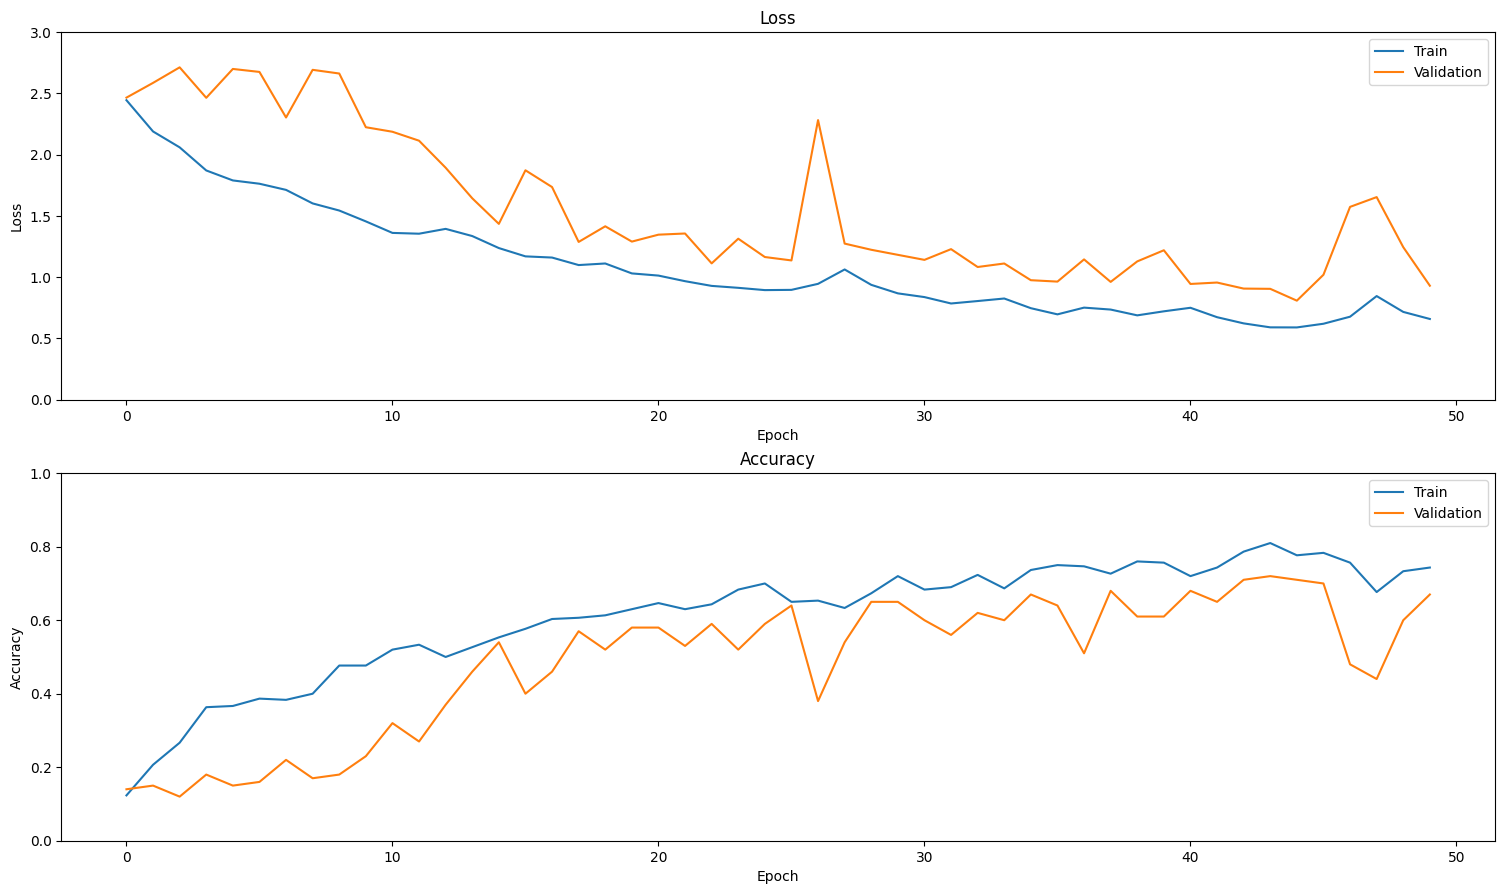

In [18]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [19]:
model.evaluate(test_ds, return_dict=True)

      1/Unknown - 1s 1s/step - loss: 0.2931 - accuracy: 0.8750

      2/Unknown - 2s 1s/step - loss: 0.2616 - accuracy: 0.9375

      3/Unknown - 3s 1s/step - loss: 0.2535 - accuracy: 0.9583

      4/Unknown - 4s 1s/step - loss: 0.3098 - accuracy: 0.9062

      5/Unknown - 6s 1s/step - loss: 0.5176 - accuracy: 0.8000

      6/Unknown - 7s 1s/step - loss: 0.4902 - accuracy: 0.8333

      7/Unknown - 8s 1s/step - loss: 0.6207 - accuracy: 0.7500

      8/Unknown - 9s 1s/step - loss: 0.6844 - accuracy: 0.7188

      9/Unknown - 11s 1s/step - loss: 0.8297 - accuracy: 0.6944

     10/Unknown - 12s 1s/step - loss: 0.9211 - accuracy: 0.6750

     11/Unknown - 13s 1s/step - loss: 0.8673 - accuracy: 0.6932

     12/Unknown - 14s 1s/step - loss: 0.8737 - accuracy: 0.6979

     13/Unknown - 15s 1s/step - loss: 0.8879 - accuracy: 0.7000

13/13 [==============================] - 15s 1s/step - loss: 0.8879 - accuracy: 0.7000


{'loss': 0.8878847360610962, 'accuracy': 0.699999988079071}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [20]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

      1/Unknown - 2s 2s/step

      2/Unknown - 3s 1s/step

      3/Unknown - 4s 1s/step

      4/Unknown - 5s 1s/step

      5/Unknown - 7s 1s/step

      6/Unknown - 8s 1s/step

      7/Unknown - 9s 1s/step

      8/Unknown - 10s 1s/step

      9/Unknown - 11s 1s/step

     10/Unknown - 13s 1s/step

     11/Unknown - 14s 1s/step

     12/Unknown - 15s 1s/step

     13/Unknown - 16s 1s/step

     14/Unknown - 17s 1s/step

     15/Unknown - 19s 1s/step

     16/Unknown - 20s 1s/step

     17/Unknown - 21s 1s/step

     18/Unknown - 22s 1s/step

     19/Unknown - 24s 1s/step

     20/Unknown - 25s 1s/step

     21/Unknown - 26s 1s/step

     22/Unknown - 27s 1s/step

     23/Unknown - 28s 1s/step

     24/Unknown - 30s 1s/step

     25/Unknown - 31s 1s/step

     26/Unknown - 32s 1s/step

     27/Unknown - 33s 1s/step

     28/Unknown - 35s 1s/step

     29/Unknown - 36s 1s/step

     30/Unknown - 37s 1s/step

     31/Unknown - 38s 1s/step

     32/Unknown - 40s 1s/step

     33/Unknown - 41s 1s/step

     34/Unknown - 42s 1s/step

     35/Unknown - 43s 1s/step

     36/Unknown - 45s 1s/step

     37/Unknown - 46s 1s/step

     38/Unknown - 46s 1s/step

38/38 [==============================] - 46s 1s/step


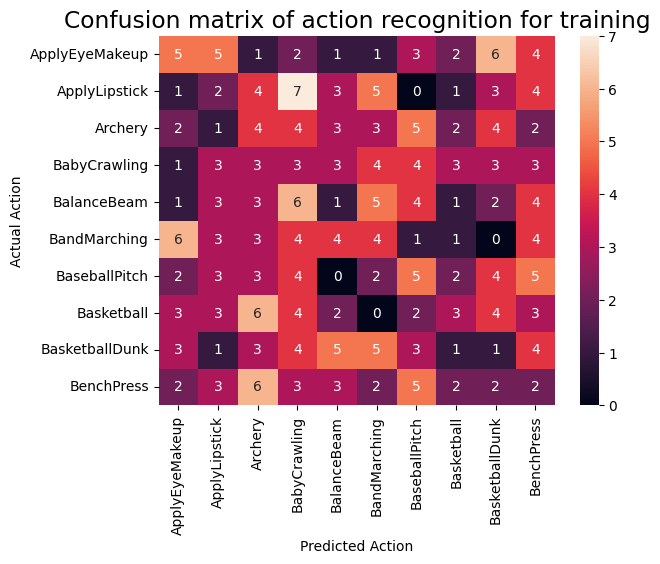

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

      1/Unknown - 1s 1s/step

      2/Unknown - 2s 1s/step

      3/Unknown - 3s 1s/step

      4/Unknown - 4s 1s/step

      5/Unknown - 6s 1s/step

      6/Unknown - 7s 1s/step

      7/Unknown - 8s 1s/step

      8/Unknown - 9s 1s/step

      9/Unknown - 10s 1s/step

     10/Unknown - 12s 1s/step

     11/Unknown - 13s 1s/step

     12/Unknown - 14s 1s/step

     13/Unknown - 15s 1s/step

13/13 [==============================] - 15s 1s/step


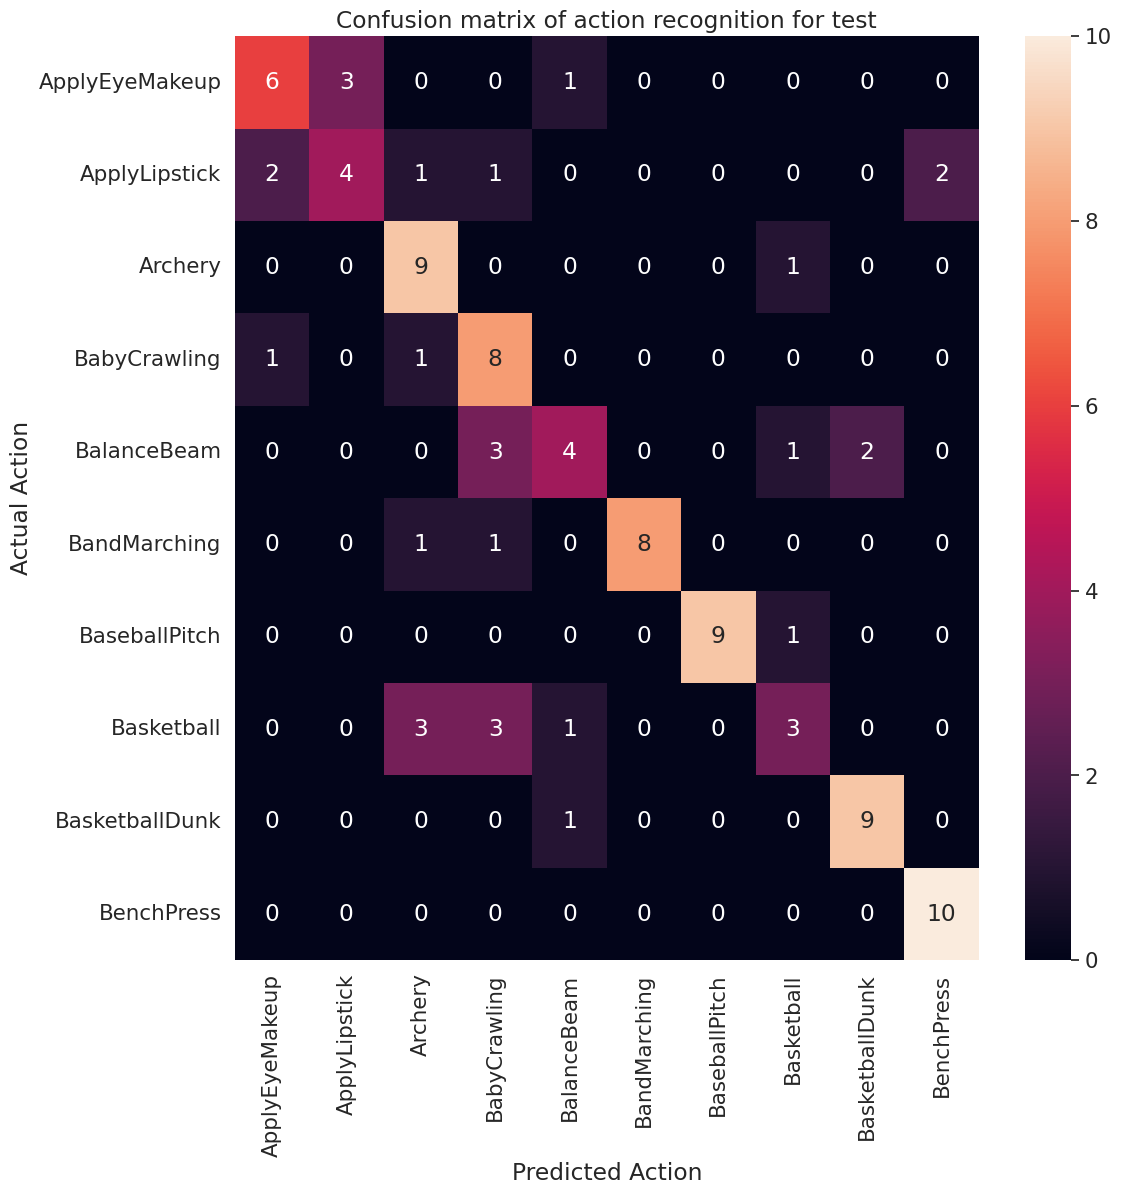

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': 0.6666666666666666,
 'ApplyLipstick': 0.5714285714285714,
 'Archery': 0.6,
 'BabyCrawling': 0.5,
 'BalanceBeam': 0.5714285714285714,
 'BandMarching': 1.0,
 'BaseballPitch': 1.0,
 'Basketball': 0.5,
 'BasketballDunk': 0.8181818181818182,
 'BenchPress': 0.8333333333333334}

In [28]:
recall

{'ApplyEyeMakeup': 0.6,
 'ApplyLipstick': 0.4,
 'Archery': 0.9,
 'BabyCrawling': 0.8,
 'BalanceBeam': 0.4,
 'BandMarching': 0.8,
 'BaseballPitch': 0.9,
 'Basketball': 0.3,
 'BasketballDunk': 0.9,
 'BenchPress': 1.0}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)